# Train NMD efficiency Predictor upon RandomForestRegressor

recreate the train.ipynb from the NMD eff paper: https://github.com/hjkng/nmdeff/blob/main/train.ipynb

In [11]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr, spearmanr
import joblib

In [2]:
# load dataset
df= pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset.csv')
df.shape

(4257, 49)

In [3]:
'''
Description of columns
        downstream_exon_count (as Downstream exon count): The number of exons downstream of the PTC
        last_exon (as Last exon): 1 if the PTC is located on the last exon; 0 otherwise
        PTC_to_start_codon (as Dist PTC to start codon): The distance between the PTC to start codon
        dist_to_stop_codon (as Dist PTC to normal stop codon): The distance between the PTC and normal stop codon
        PTC_exon_length (as PTC-containing exon length): The length of the PTC-containing exon
        PTC_to_intron (as Dist PTC to downstream EJ): The distance between the PTC and downstream exon junction
        upstream_exon_count (as Upstream exon count): The number of exons upstream of the PTC
        mRNA_half_life (as mRNA half-life): The half-life of mRNA
        50nt_to_last_EJ (as Last 50nt penultimate exon): 1 if the PTC is located on the last exon; 0 otherwise
        LOEUF (as LOEUF): Gene-level degree of mutational constraints
        AF: (as Allele frequency): Allele frequency in gnomAD database
        5UTR_length: (as 5'UTR length) : The length of 5'UTR
        3UTR_length: (as 3'UTR length) : The length of 3'UTR
        Transcript_length: (as Transcript length) : The length of the transcript
'''

# we expect to match names of columns to your datasets
cols = ['downstream_exon_count', 'last_exon', 'PTC_to_start_codon',
        'dist_to_stop_codon', 'PTC_exon_length', 'PTC_to_intron','upstream_exon_count',
        'mRNA_half_life','50nt_to_last_EJ','LOEUF', 'AF', '5UTR_length', '3UTR_length', 'Transcript_length']

df[cols].head(1)

,downstream_exon_count,last_exon,PTC_to_start_codon,dist_to_stop_codon,PTC_exon_length,PTC_to_intron,upstream_exon_count,mRNA_half_life,50nt_to_last_EJ,LOEUF,AF,5UTR_length,3UTR_length,Transcript_length
0,1,0,996,369,89,84,7,592.689818,0,0.737,0.0,356,370,1722


In [4]:
df[cols].isnull().sum()

downstream_exon_count      0
last_exon                  0
PTC_to_start_codon         0
dist_to_stop_codon         0
PTC_exon_length            0
PTC_to_intron              0
upstream_exon_count        0
mRNA_half_life             0
50nt_to_last_EJ            0
LOEUF                    130
AF                         0
5UTR_length                0
3UTR_length                0
Transcript_length          0
dtype: int64

In [5]:
df = df.loc[df['LOEUF'].notnull()].reset_index(drop=True)
df.shape

(4127, 49)

In [6]:
regr = RandomForestRegressor(max_features = 3, n_estimators=10000, n_jobs=-1)

In [7]:
# applying cross-valiation method for evaluation
scores = cross_val_score(regr, df[cols], df['NMD_efficiency'], cv=5)
print(f'r2: {np.mean(scores):5f}, std: {np.std(scores):5f}')

r2: 0.437378, std: 0.070214


In [8]:
X = df[cols]
y = df['NMD_efficiency']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [9]:
regr.fit(X_train, y_train)
regr.score(X_test, y_test)
print(f'r2: {regr.score(X_test, y_test):5f}')

r2: 0.459517


### Importance of trained randomforest regressor

In [10]:
importance_df = pd.DataFrame({'feature':regr.feature_names_in_, 
                              'importance': regr.feature_importances_})

importance_df 

,feature,importance
0,downstream_exon_count,0.136237
1,last_exon,0.078735
2,PTC_to_start_codon,0.093608
3,dist_to_stop_codon,0.083604
4,PTC_exon_length,0.090074
5,PTC_to_intron,0.085609
6,upstream_exon_count,0.050831
7,mRNA_half_life,0.060397
8,50nt_to_last_EJ,0.019740
9,LOEUF,0.065147


In [12]:
# Save the trained model
pickle.dump(regr, open('nmd_eff_predictor', 'wb'))

### Feature correlation

In [13]:
df.columns

Index(['Cancer_type', 'Cancer_type_count', 'NMF_cluster', 'build',
       'chromosome', 'start', 'end', 'Hugo_Symbol', 'Transcript_ID', 'HGVSc',
       'HGVSp', 't_vaf', 't_depth', 'n_vaf', 'n_depth', 'PTC_pos_codon',
       'PTC_to_start_codon', 'upstream_exon_count', 'total_exon_count',
       'downstream_exon_count', 'last_exon', '50nt_to_last_EJ',
       'PTC_exon_length', 'PTC_to_intron', 'cDNAcnt', 'PTC Location',
       'Less than 150nt to start', 'Distance to downstream AUG (codon)',
       'Distance to downstream AUG', 'Downstream AUG', 'Last exon',
       'Last 50nt penultimate exon', 'Last exon OR Last 50nt penultimate exon',
       'Exon length longer than 407nt', '4 Rules combined', 'tpm_unstranded_x',
       'dist_to_stop_codon', 'mRNA_half_life', 'VAF_RNA', 'depth_RNA',
       'VAF_DNA_RNA_ratio', 'NMD_efficiency', 'AF', 'AF Group', 'LOEUF',
       'LOEUF_bin', '5UTR_length', '3UTR_length', 'Transcript_length'],
      dtype='object')

In [14]:
importance_lookup = dict(zip(importance_df["feature"], importance_df["importance"]))

def format_p_value(p):
    if p < 0.001:
        return "p < 0.001"
    else:
        return f"p = {p:.3f}"

def compute_feature_correlations(df, features, target="NMD_efficiency"):
    results = []
    for feat in features:
        x = df[feat].dropna()
        y = df.loc[x.index, target].dropna()
        if len(x) > 5:  # avoid tiny groups
            pear, p_p = pearsonr(x, y)
            spear, p_s = spearmanr(x, y)            
            results.append({
                "feature": feat,
                "pearson_r": pear,
                # "spearman_r": spear,
                "p_value": format_p_value(p_p),
                "importance": importance_lookup.get(feat, None)
            })
    return pd.DataFrame(results)

features = ["downstream_exon_count", "PTC_to_start_codon", "PTC_exon_length", "3UTR_length", "PTC_to_intron", "last_exon", "LOEUF", "Transcript_length", "mRNA_half_life", "5UTR_length", 
            "upstream_exon_count", "AF", "50nt_to_last_EJ"]

corr_df = compute_feature_correlations(df, features)
corr_df

,feature,pearson_r,p_value,importance
0,downstream_exon_count,0.258525,p < 0.001,0.136237
1,PTC_to_start_codon,-0.076805,p < 0.001,0.093608
2,PTC_exon_length,-0.180007,p < 0.001,0.090074
3,3UTR_length,0.095832,p < 0.001,0.086977
4,PTC_to_intron,-0.171502,p < 0.001,0.085609
5,last_exon,-0.478237,p < 0.001,0.078735
6,LOEUF,-0.123524,p < 0.001,0.065147
7,Transcript_length,-0.019358,p = 0.214,0.063764
8,mRNA_half_life,0.124783,p < 0.001,0.060397
9,5UTR_length,-0.072539,p < 0.001,0.059973


### NMD efficiency

- Was genau bedeutet die Efficiency nochmal?
- Wie ist der Wertebereich?
- Hast du ein Histogramm?


--- Beschreibung von NMD_efficiency ---
count    4257.000000
mean        1.014920
std         1.265065
min        -1.670936
25%        -0.023687
50%         0.788255
75%         1.930212
max         6.839370
Name: NMD_efficiency, dtype: float64
Anzahl fehlender Werte: 0

Wertebereich: -1.671 bis 6.839


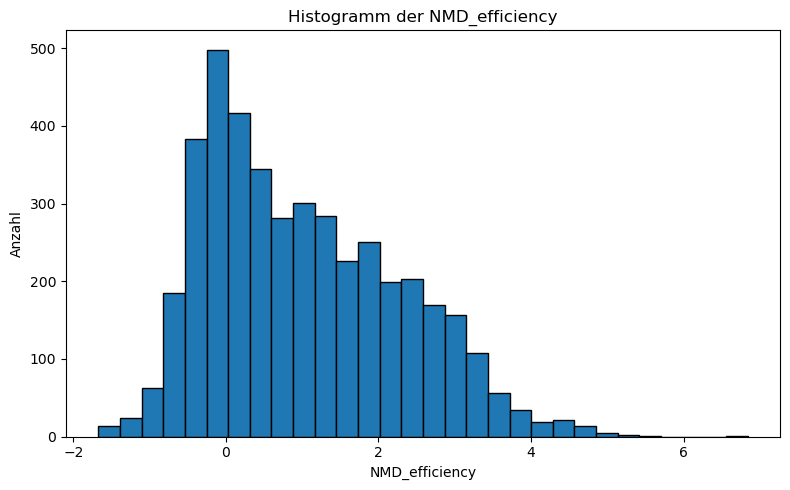

In [15]:
# Lade den TCGA Benchmark Datensatz
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset.csv')

# 1. Beschreibung der Verteilung (inkl. NaNs)
print("\n--- Beschreibung von NMD_efficiency ---")
print(df["NMD_efficiency"].describe())
print(f"Anzahl fehlender Werte: {df['NMD_efficiency'].isnull().sum()}")

# 2. Wertebereich
min_eff = df["NMD_efficiency"].min()
max_eff = df["NMD_efficiency"].max()
print(f"\nWertebereich: {min_eff:.3f} bis {max_eff:.3f}")

# 3. Histogramm anzeigen
plt.figure(figsize=(8, 5))
df["NMD_efficiency"].hist(bins=30, edgecolor='black')
plt.title("Histogramm der NMD_efficiency")
plt.xlabel("NMD_efficiency")
plt.ylabel("Anzahl")
plt.grid(False)
plt.tight_layout()
plt.show()

In [16]:
### Validation using an independent dataset (MMRF-TARGET)

### Validation using an independent dataset (MMRF-TARGET)

In [17]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.ensemble import RandomForestRegressor

In [18]:
# load dataset
df = pd.read_csv('./resources/MMRF_benchmark/MMRF_TARGET_dataset.csv')
df.shape

(556, 33)

In [19]:
cols = ['downstream_exon_count', 'last_exon', 'PTC_to_start_codon',
        'dist_to_stop_codon', 'PTC_exon_length', 'PTC_to_intron','upstream_exon_count',
        'mRNA_half_life','50nt_to_last_EJ','LOEUF', 'AF', '5UTR_length', '3UTR_length', 'Transcript_length']

df[cols].head(1)

,downstream_exon_count,last_exon,PTC_to_start_codon,dist_to_stop_codon,PTC_exon_length,PTC_to_intron,upstream_exon_count,mRNA_half_life,50nt_to_last_EJ,LOEUF,AF,5UTR_length,3UTR_length,Transcript_length
0,19,0,4189,4718,990,31,10,315.133085,0,0.557,0.0,349,4719,9257


In [20]:
df[cols].isnull().sum()

downstream_exon_count     0
last_exon                 0
PTC_to_start_codon        0
dist_to_stop_codon        0
PTC_exon_length           0
PTC_to_intron             0
upstream_exon_count       0
mRNA_half_life            0
50nt_to_last_EJ           0
LOEUF                    74
AF                        0
5UTR_length               0
3UTR_length               0
Transcript_length         0
dtype: int64

In [21]:
df = df.loc[df['LOEUF'].notnull()].reset_index(drop=True)
df.shape

(482, 33)

In [22]:
regr = pickle.load(open('./nmd_eff_predictor', 'rb'))

def predict_NMD_efficiency(downstream_exon_count:int, last_exon:int, PTC_to_start_codon:int, 
                           dist_to_stop_codon:int, PTC_exon_length:int, PTC_to_intron:int, upstream_exon_count:int, 
                           mRNA_half_life:float, c50nt_to_last_EJ:int, LOEUF:float, AF:float,
                           UTR5_length:int, UTR3_length:int, Transcript_length:int) -> float:
    
    input_value =[[downstream_exon_count, last_exon, PTC_to_start_codon,
                   dist_to_stop_codon, PTC_exon_length, PTC_to_intron, upstream_exon_count,
                   mRNA_half_life, c50nt_to_last_EJ, LOEUF, AF,
                   UTR5_length, UTR3_length, Transcript_length]]
    
    assert sum([np.isnan(value) for value in input_value[0]]) == 0, 'Replace NaN value'
    
    pred = regr.predict(input_value)[0]
    
    return pred


def predict_NMD_efficiency_df(examples):
    df = pd.DataFrame(examples)

    assert df.isnull().sum().sum() == 0, 'Replace NaN value'

    pred = regr.predict(df)

    return pred

In [23]:
pred = regr.predict(df[cols])
c, p = stats.pearsonr(pred, df['NMD_efficiency'])
print("Pearson R :" , c)
print("P-value : " , p)

Pearson R : 0.46717685669124875
P-value :  1.675613131756445e-27


Pearson R: 0.4671768566912487
P-value: 1.6756131317565533e-27
R^2: 0.21825421542791554


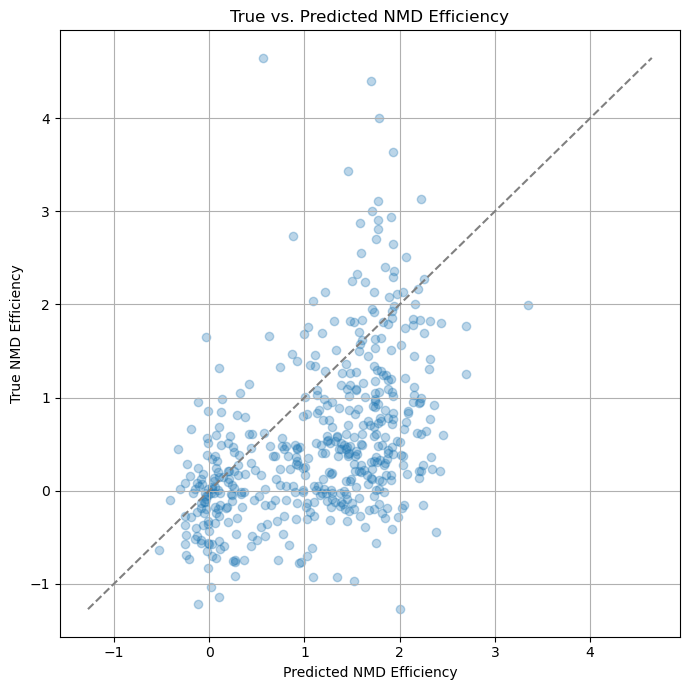

In [24]:
y_true = df['NMD_efficiency']
y_pred = regr.predict(df[cols]) # = pred

# Pearson correlation
c, p = stats.pearsonr(y_pred, y_true)
print("Pearson R:", c)
print("P-value:", p)
print("R^2:", np.square(c))

# min / max value for line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())

# Plot: True vs Predicted
plt.figure(figsize=(7, 7))
plt.scatter(y_pred, y_true, alpha=0.3)
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')
plt.ylabel("True NMD Efficiency")
plt.xlabel("Predicted NMD Efficiency")
plt.title("True vs. Predicted NMD Efficiency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
np.square(c)

0.21825421542791554

In [26]:
y_true

0      0.800328
1      0.374699
2     -0.150942
3     -0.096187
4      0.379962
         ...   
477    0.021676
478    0.054982
479    1.263034
480    2.933727
481    1.017487
Name: NMD_efficiency, Length: 482, dtype: float64

In [27]:
y_pred

array([ 9.88235434e-01,  6.40543593e-02,  2.04237946e+00,  4.73453274e-01,
        3.11812840e-01,  2.53795356e-01,  1.80104307e+00,  1.70362476e+00,
        1.15707842e+00,  1.33771529e-01, -1.58291219e-02, -3.07096722e-01,
       -1.14356682e-01,  7.05924501e-01,  2.30848485e+00,  2.21212134e+00,
        2.13644030e+00,  1.90713030e+00,  1.21696693e+00,  1.28598172e+00,
        1.72731780e+00,  1.57631861e+00,  1.43326414e+00,  2.00456582e+00,
        5.62164724e-01,  1.12315978e-01,  2.36023233e+00,  1.45102172e+00,
        1.76877196e+00,  1.73861060e+00,  1.52846825e+00,  1.84685768e+00,
        1.09089551e-01, -2.00459477e-02,  1.00931460e+00, -1.18134137e-01,
        1.49623246e+00,  1.87716145e+00,  1.45645390e+00, -3.54588300e-02,
        2.62230958e-01,  2.03364089e-01,  9.98840607e-01,  1.61793066e+00,
        6.73903428e-01,  2.31940923e+00,  1.59358577e+00,  1.58871204e+00,
       -5.24049628e-02,  1.44483167e+00,  1.58882246e+00,  1.86865488e+00,
        2.19915527e-01,  

In [28]:
from sklearn.metrics import r2_score
r2_score(np.array(y_true), y_pred)

-0.4030127424783274

# Train a model for NMD Scanner

Fragen zum Model:
- Tue ich TCGA und MMRF Output joinen und gejoint als Input für mein Model oder getrennt?
- Welche Spalte ist mein y?

In [29]:
df.shape

(482, 33)

In [30]:
# merge NMD_Scanner Output von TCGA mit dem NMD_efficiency score vom Original TCGA Benchmark
#df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/Output-260825/tcga_dataset_final_nmd_results.csv') # nmd scanner output on tcga
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/Output-210925/tcga_dataset_final_nmd_results.csv') # nmd scanner output on tcga
df2 = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset.csv')

# 1. Remove transcript version number from NMD Scanner output (df)
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]

# 2. Adjust start_variant position (+1) to match TCGA coordinates
df['start_variant'] = df['start_variant'] + 1
#df['end_variant'] = df['end_variant'] - 1

# 3. Rename TCGA columns to match NMD Scanner
df2 = df2.rename(columns={
    'Transcript_ID': 'transcript_id',
    'start': 'start_variant',
    'end': 'end_variant'
})

# 4. Select only relevant columns from TCGA
df2_subset = df2[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']]

# 5. Merge
df_merged = pd.merge(df, df2_subset, on=['transcript_id', 'start_variant', 'end_variant'], how='inner')

print("Merged shape:", df_merged.shape)
print("Missing NMD_efficiency values:", df_merged['NMD_efficiency'].isnull().sum())
print(df_merged[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']].head())

Merged shape: (4246, 75)
Missing NMD_efficiency values: 0
     transcript_id  start_variant  end_variant  NMD_efficiency
0  ENST00000000412        8942472      8942472        0.389934
1  ENST00000000442       64314869     64314869        0.425091
2  ENST00000002165      143497446    143497446        1.165452
3  ENST00000002829       50174085     50174085        1.631418
4  ENST00000003084      117627525    117627525        0.999051


In [31]:
df_merged

,transcript_id,variant_id,ref_cds_start,ref_cds_stop,ref_cds_seq,ref_cds_len,alt_cds_start,alt_cds_stop,alt_cds_seq,alt_cds_len,...,ptc_exon_length,stop_codon_distance,ptc_to_intron,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,NMD_efficiency
0,ENST00000000412,.,8941817,8946404,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,834,8941817,8946404,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,834,...,127.0,177.0,57.0,False,False,False,False,False,False,0.389934
1,ENST00000000442,.,64307179,64315966,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,1272,64307179,64315966,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,1272,...,171.0,570.0,43.0,False,False,False,False,False,False,0.425091
2,ENST00000002165,.,143495706,143511634,ATGCGGCCCCAGGAGCTCCCCAGGCTCGCGTTCCCGTTGCTGCTGT...,1404,143495706,143511634,ATGCGGCCCCAGGAGCTCCCCAGGCTCGCGTTCCCGTTGCTGCTGT...,1404,...,109.0,198.0,60.0,False,False,False,False,False,False,1.165452
3,ENST00000002829,.,50159622,50188115,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,2358,50159622,50188115,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,2358,...,63.0,2049.0,30.0,False,False,False,False,False,False,1.631418
4,ENST00000003084,.,117480094,117667108,ATGCAGAGGTCGCCTCTGGAAAAGGCCAGCGTTGTCTCCAAACTTT...,4443,117480094,117667108,ATGCAGAGGTCGCCTCTGGAAAAGGCCAGCGTTGTCTCCAAACTTT...,4443,...,249.0,969.0,246.0,False,False,False,False,False,False,0.999051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4241,ENST00000607197,.,138404495,138413078,ATGGCCGAGCCGCTCCAGCCAGACCCCGGGGCGGCCGAGGACGCGG...,618,138404495,138413078,ATGGCCGAGCCGCTCCAGCCAGACCCCGGGGCGGCCGAGGACGCGG...,618,...,9318.0,159.0,162.0,True,False,True,False,False,True,-0.267592
4242,ENST00000607484,.,33697652,33711686,ATGGCGGCCAGCCGGTACCGGCGTTTTCTTAAGCTCTGTGAGGAAT...,381,33697652,33711686,ATGGCGGCCAGCCGGTACCGGCGTTTTCTTAAGCTCTGTGAGGAAT...,381,...,75.0,195.0,30.0,False,False,False,False,False,False,-0.049774
4243,ENST00000608796,.,128276340,128288716,CTGGACCCTCTTGCGCCATTGAACCCCCTGATCCGGGGGCCTCGGA...,513,128276340,128288716,CTGGACCCTCTTGCGCCATTGAACCCCCTGATCCGGGGGCCTCGGA...,513,...,339.0,54.0,57.0,True,False,False,True,False,True,-0.407414
4244,ENST00000610020,.,92299073,92380874,ATGGCGGACTTCGCTGGGCCGTCTTCTGCCGGCCGCAAGGCCGGGG...,1839,92299073,92380874,ATGGCGGACTTCGCTGGGCCGTCTTCTGCCGGCCGCAAGGCCGGGG...,1839,...,150.0,NaN,45.0,False,False,False,False,False,False,0.537657



--- Beschreibung von NMD_efficiency ---
count    4246.000000
mean        1.013731
std         1.265040
min        -1.670936
25%        -0.023829
50%         0.788079
75%         1.928361
max         6.839370
Name: NMD_efficiency, dtype: float64
Anzahl fehlender Werte: 0

Wertebereich: -1.671 bis 6.839


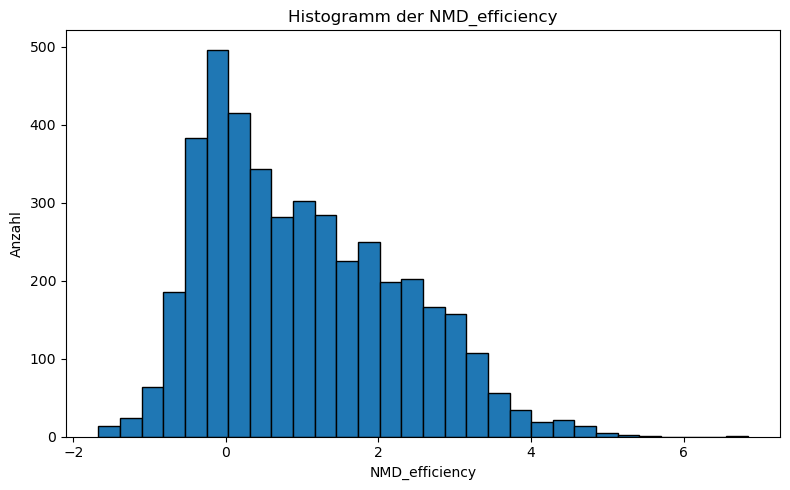

In [32]:
# 1. Beschreibung der Verteilung (inkl. NaNs)
print("\n--- Beschreibung von NMD_efficiency ---")
print(df_merged["NMD_efficiency"].describe())
print(f"Anzahl fehlender Werte: {df_merged['NMD_efficiency'].isnull().sum()}")

# 2. Wertebereich
min_eff = df_merged["NMD_efficiency"].min()
max_eff = df_merged["NMD_efficiency"].max()
print(f"\nWertebereich: {min_eff:.3f} bis {max_eff:.3f}")

# 3. Histogramm anzeigen
plt.figure(figsize=(8, 5))
df_merged["NMD_efficiency"].hist(bins=30, edgecolor='black')
plt.title("Histogramm der NMD_efficiency")
plt.xlabel("NMD_efficiency")
plt.ylabel("Anzahl")
plt.grid(False)
plt.tight_layout()
plt.show()

In [33]:
# only 9 rows missing between original TCGA dataset and joined dataset

In [34]:
df_merged.shape

(4246, 75)

In [35]:
df_merged.columns

Index(['transcript_id', 'variant_id', 'ref_cds_start', 'ref_cds_stop',
       'ref_cds_seq', 'ref_cds_len', 'alt_cds_start', 'alt_cds_stop',
       'alt_cds_seq', 'alt_cds_len', 'chromosome', 'gene_id', 'strand', 'ref',
       'alt', 'start_variant', 'end_variant', 'ref_cds_info', 'alt_cds_info',
       'cds_in_transcript', 'ref_start_codon_pos', 'ref_start_codon_exon',
       'ref_last_codon', 'ref_valid_stop', 'ref_first_stop_codon',
       'ref_first_stop_pos', 'ref_num_stop_codons', 'ref_all_stop_codons',
       'ref_stop_codon_exons', 'ref_is_premature', 'alt_start_codon_pos',
       'alt_start_codon_exon', 'alt_last_codon', 'alt_valid_stop',
       'alt_first_stop_codon', 'alt_first_stop_pos', 'alt_num_stop_codons',
       'alt_all_stop_codons', 'alt_stop_codon_exons', 'alt_is_premature',
       'start_loss', 'stop_loss', 'transcript_start', 'transcript_end',
       'transcript_seq', 'transcript_length', 'alt_transcript_seq',
       'alt_transcript_length', 'transcript_exon_info'

In [36]:
# check if ptc_less_than_150nt_to_start == nmd_start_proximal_rule
(df_merged["ptc_less_than_150nt_to_start"] == df_merged["nmd_start_proximal_rule"]).all()

True

In [37]:
# Select the columns that we want to have as X (our features)
cols = ['start_loss', 'stop_loss', 'nmd_last_exon_rule', 'nmd_50nt_penultimate_rule', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape', # nmd escape = X or Y?
        'utr3_length', 'utr5_length', 'alt_transcript_length', 'total_exon_count', 'upstream_exon_count', 'downstream_exon_count', 'ptc_to_start_codon', 'ptc_exon_length', 'ptc_to_intron',
        'ptc_less_than_150nt_to_start', 'stop_codon_distance', 'transcript_length']

df_merged[cols].head(1)

,start_loss,stop_loss,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,utr3_length,utr5_length,alt_transcript_length,total_exon_count,upstream_exon_count,downstream_exon_count,ptc_to_start_codon,ptc_exon_length,ptc_to_intron,ptc_less_than_150nt_to_start,stop_codon_distance,transcript_length
0,False,False,False,False,False,False,False,False,159,1457,2450.0,7,5.0,1.0,654.0,127.0,57.0,False,177.0,2450


In [38]:
df_merged[cols].isnull().sum()

start_loss                       0
stop_loss                        0
nmd_last_exon_rule               0
nmd_50nt_penultimate_rule        0
nmd_long_exon_rule               0
nmd_start_proximal_rule          0
nmd_single_exon_rule             0
nmd_escape                       0
utr3_length                      0
utr5_length                      0
alt_transcript_length           10
total_exon_count                 0
upstream_exon_count              0
downstream_exon_count            0
ptc_to_start_codon               3
ptc_exon_length                  0
ptc_to_intron                    0
ptc_less_than_150nt_to_start     0
stop_codon_distance             10
transcript_length                0
dtype: int64

In [39]:
df_merged.shape

(4246, 75)

In [40]:
df_merged

,transcript_id,variant_id,ref_cds_start,ref_cds_stop,ref_cds_seq,ref_cds_len,alt_cds_start,alt_cds_stop,alt_cds_seq,alt_cds_len,...,ptc_exon_length,stop_codon_distance,ptc_to_intron,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,NMD_efficiency
0,ENST00000000412,.,8941817,8946404,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,834,8941817,8946404,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,834,...,127.0,177.0,57.0,False,False,False,False,False,False,0.389934
1,ENST00000000442,.,64307179,64315966,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,1272,64307179,64315966,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,1272,...,171.0,570.0,43.0,False,False,False,False,False,False,0.425091
2,ENST00000002165,.,143495706,143511634,ATGCGGCCCCAGGAGCTCCCCAGGCTCGCGTTCCCGTTGCTGCTGT...,1404,143495706,143511634,ATGCGGCCCCAGGAGCTCCCCAGGCTCGCGTTCCCGTTGCTGCTGT...,1404,...,109.0,198.0,60.0,False,False,False,False,False,False,1.165452
3,ENST00000002829,.,50159622,50188115,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,2358,50159622,50188115,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,2358,...,63.0,2049.0,30.0,False,False,False,False,False,False,1.631418
4,ENST00000003084,.,117480094,117667108,ATGCAGAGGTCGCCTCTGGAAAAGGCCAGCGTTGTCTCCAAACTTT...,4443,117480094,117667108,ATGCAGAGGTCGCCTCTGGAAAAGGCCAGCGTTGTCTCCAAACTTT...,4443,...,249.0,969.0,246.0,False,False,False,False,False,False,0.999051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4241,ENST00000607197,.,138404495,138413078,ATGGCCGAGCCGCTCCAGCCAGACCCCGGGGCGGCCGAGGACGCGG...,618,138404495,138413078,ATGGCCGAGCCGCTCCAGCCAGACCCCGGGGCGGCCGAGGACGCGG...,618,...,9318.0,159.0,162.0,True,False,True,False,False,True,-0.267592
4242,ENST00000607484,.,33697652,33711686,ATGGCGGCCAGCCGGTACCGGCGTTTTCTTAAGCTCTGTGAGGAAT...,381,33697652,33711686,ATGGCGGCCAGCCGGTACCGGCGTTTTCTTAAGCTCTGTGAGGAAT...,381,...,75.0,195.0,30.0,False,False,False,False,False,False,-0.049774
4243,ENST00000608796,.,128276340,128288716,CTGGACCCTCTTGCGCCATTGAACCCCCTGATCCGGGGGCCTCGGA...,513,128276340,128288716,CTGGACCCTCTTGCGCCATTGAACCCCCTGATCCGGGGGCCTCGGA...,513,...,339.0,54.0,57.0,True,False,False,True,False,True,-0.407414
4244,ENST00000610020,.,92299073,92380874,ATGGCGGACTTCGCTGGGCCGTCTTCTGCCGGCCGCAAGGCCGGGG...,1839,92299073,92380874,ATGGCGGACTTCGCTGGGCCGTCTTCTGCCGGCCGCAAGGCCGGGG...,1839,...,150.0,NaN,45.0,False,False,False,False,False,False,0.537657


In [41]:
# drop non-PTCs: if alt_is_premature = False, und falls alt_is_premature = True dann darf ref_is_premature nicht True sein

# 1. remove rows with ref_is_premature = True weil dann ist Annotations-Fehler und falls alt_is_premature = True dann ist es nicht premature
df_filtered = df_merged[~df_merged["ref_is_premature"]]
rem_rows1 = df_merged.shape[0] - df_filtered.shape[0]

print(f"Rows removed in step 1 (ref_is_premature=True): {rem_rows1}")
print(f"Remaining rows: {df_filtered.shape[0]}")

# 2. remove rows with ref_is_premature = False und alt_is_premature = False
step2_rows = df_filtered.shape[0]
df_filtered = df_filtered[~((df_filtered["ref_is_premature"] == False) & (df_filtered["alt_is_premature"] == False))]
rem_rows2 = step2_rows - df_filtered.shape[0]

print(f"Rows removed in step 2 (both ref and alt not premature): {rem_rows2}")
print(f"Remaining rows: {df_filtered.shape[0]}")

df_filtered = df_filtered.reset_index(drop=True)
df_filtered.head()

Rows removed in step 1 (ref_is_premature=True): 6
Remaining rows: 4240
Rows removed in step 2 (both ref and alt not premature): 0
Remaining rows: 4240


,transcript_id,variant_id,ref_cds_start,ref_cds_stop,ref_cds_seq,ref_cds_len,alt_cds_start,alt_cds_stop,alt_cds_seq,alt_cds_len,...,ptc_exon_length,stop_codon_distance,ptc_to_intron,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,NMD_efficiency
0,ENST00000000412,.,8941817,8946404,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,834,8941817,8946404,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,834,...,127.0,177.0,57.0,False,False,False,False,False,False,0.389934
1,ENST00000000442,.,64307179,64315966,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,1272,64307179,64315966,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,1272,...,171.0,570.0,43.0,False,False,False,False,False,False,0.425091
2,ENST00000002165,.,143495706,143511634,ATGCGGCCCCAGGAGCTCCCCAGGCTCGCGTTCCCGTTGCTGCTGT...,1404,143495706,143511634,ATGCGGCCCCAGGAGCTCCCCAGGCTCGCGTTCCCGTTGCTGCTGT...,1404,...,109.0,198.0,60.0,False,False,False,False,False,False,1.165452
3,ENST00000002829,.,50159622,50188115,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,2358,50159622,50188115,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,2358,...,63.0,2049.0,30.0,False,False,False,False,False,False,1.631418
4,ENST00000003084,.,117480094,117667108,ATGCAGAGGTCGCCTCTGGAAAAGGCCAGCGTTGTCTCCAAACTTT...,4443,117480094,117667108,ATGCAGAGGTCGCCTCTGGAAAAGGCCAGCGTTGTCTCCAAACTTT...,4443,...,249.0,969.0,246.0,False,False,False,False,False,False,0.999051


In [42]:
df_filtered[cols].isnull().sum()

start_loss                       0
stop_loss                        0
nmd_last_exon_rule               0
nmd_50nt_penultimate_rule        0
nmd_long_exon_rule               0
nmd_start_proximal_rule          0
nmd_single_exon_rule             0
nmd_escape                       0
utr3_length                      0
utr5_length                      0
alt_transcript_length           10
total_exon_count                 0
upstream_exon_count              0
downstream_exon_count            0
ptc_to_start_codon               1
ptc_exon_length                  0
ptc_to_intron                    0
ptc_less_than_150nt_to_start     0
stop_codon_distance             10
transcript_length                0
dtype: int64

In [43]:
# drop null values
df_filtered = df_filtered.loc[df_filtered['alt_transcript_length'].notnull()].reset_index(drop=True)
df_filtered = df_filtered.loc[df_filtered['ptc_to_start_codon'].notnull()].reset_index(drop=True)
df_filtered.shape

(4229, 75)

In [44]:
df_filtered[cols].isnull().sum()

start_loss                      0
stop_loss                       0
nmd_last_exon_rule              0
nmd_50nt_penultimate_rule       0
nmd_long_exon_rule              0
nmd_start_proximal_rule         0
nmd_single_exon_rule            0
nmd_escape                      0
utr3_length                     0
utr5_length                     0
alt_transcript_length           0
total_exon_count                0
upstream_exon_count             0
downstream_exon_count           0
ptc_to_start_codon              0
ptc_exon_length                 0
ptc_to_intron                   0
ptc_less_than_150nt_to_start    0
stop_codon_distance             0
transcript_length               0
dtype: int64

In [45]:
df_filtered.shape

(4229, 75)

In [46]:
regr = RandomForestRegressor(max_features = 3, n_estimators=10000, n_jobs=-1)

In [47]:
# applying cross-valiation method for evaluation
scores = cross_val_score(regr, df_filtered[cols], df_filtered['NMD_efficiency'], cv=5)
print(f'r2: {np.mean(scores):5f}, std: {np.std(scores):5f}')

r2: 0.388321, std: 0.033595


In [48]:
X = df_filtered[cols]
y = df_filtered['NMD_efficiency']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [49]:
regr.fit(X_train, y_train)
regr.score(X_test, y_test)
print(f'r2: {regr.score(X_test, y_test):5f}')

r2: 0.458183


### Importance of trained randomforest regressor

In [50]:
importance_df = pd.DataFrame({'feature':regr.feature_names_in_, 
                              'importance': regr.feature_importances_})

importance_df = importance_df.sort_values(by="importance", ascending=False).reset_index(drop=True)
importance_df 

,feature,importance
0,downstream_exon_count,0.117991
1,ptc_exon_length,0.101256
2,stop_codon_distance,0.095416
3,ptc_to_intron,0.084140
4,ptc_to_start_codon,0.081546
5,nmd_escape,0.067811
6,utr5_length,0.065382
7,utr3_length,0.064354
8,transcript_length,0.063779
9,alt_transcript_length,0.063617


In [51]:
# Save the trained model
pickle.dump(regr, open('nmd_eff_predictor2', 'wb'))

### Prediction

In [52]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.ensemble import RandomForestRegressor

In [53]:
# merge NMD_Scanner Output von MMRF mit dem NMD_efficiency score vom Original TCGA Benchmark
# df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/Output-260825/MMRF_TARGET_dataset_final_nmd_results.csv')
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/Output-210925/MMRF_TARGET_dataset_final_nmd_results.csv')
df2 = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/MMRF_benchmark/MMRF_TARGET_dataset.csv')

# 1. Remove transcript version number from NMD Scanner output (df)
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]

# 2. Adjust start_variant position (+1) to match TCGA coordinates
df['start_variant'] = df['start_variant'] + 1
#df['end_variant'] = df['end_variant'] - 1

# 3. Rename TCGA columns to match NMD Scanner
df2 = df2.rename(columns={
    'Transcript_ID': 'transcript_id',
    'start': 'start_variant'
})

# 4. Select only relevant columns from TCGA
df2_subset = df2[['transcript_id', 'start_variant', 'NMD_efficiency']]

# 5. Merge
df_merged = pd.merge(df, df2_subset, on=['transcript_id', 'start_variant'], how='inner')

# ✅ Inspect result
print("Merged shape:", df_merged.shape)
print("Missing NMD_efficiency values:", df_merged['NMD_efficiency'].isnull().sum())
print(df_merged[['transcript_id', 'start_variant', 'NMD_efficiency']].head())

Merged shape: (549, 75)
Missing NMD_efficiency values: 0
     transcript_id  start_variant  NMD_efficiency
0  ENST00000038176       58609624        0.710493
1  ENST00000040738       13576985        0.022368
2  ENST00000155093        2979509       -0.019109
3  ENST00000156471       34857043        0.040062
4  ENST00000202917      112917610        0.987014


In [54]:
df_merged.columns

Index(['transcript_id', 'variant_id', 'ref_cds_start', 'ref_cds_stop',
       'ref_cds_seq', 'ref_cds_len', 'alt_cds_start', 'alt_cds_stop',
       'alt_cds_seq', 'alt_cds_len', 'chromosome', 'gene_id', 'strand', 'ref',
       'alt', 'start_variant', 'end_variant', 'ref_cds_info', 'alt_cds_info',
       'cds_in_transcript', 'ref_start_codon_pos', 'ref_start_codon_exon',
       'ref_last_codon', 'ref_valid_stop', 'ref_first_stop_codon',
       'ref_first_stop_pos', 'ref_num_stop_codons', 'ref_all_stop_codons',
       'ref_stop_codon_exons', 'ref_is_premature', 'alt_start_codon_pos',
       'alt_start_codon_exon', 'alt_last_codon', 'alt_valid_stop',
       'alt_first_stop_codon', 'alt_first_stop_pos', 'alt_num_stop_codons',
       'alt_all_stop_codons', 'alt_stop_codon_exons', 'alt_is_premature',
       'start_loss', 'stop_loss', 'transcript_start', 'transcript_end',
       'transcript_seq', 'transcript_length', 'alt_transcript_seq',
       'alt_transcript_length', 'transcript_exon_info'

In [55]:
# Select the columns that we want to have as X (our features)
cols = ['start_loss', 'stop_loss', 'nmd_last_exon_rule', 'nmd_50nt_penultimate_rule', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape', # nmd escape = X or Y?
        'utr3_length', 'utr5_length', 'alt_transcript_length', 'total_exon_count', 'upstream_exon_count', 'downstream_exon_count', 'ptc_to_start_codon', 'ptc_exon_length', 'ptc_to_intron',
        'ptc_less_than_150nt_to_start', 'stop_codon_distance', 'transcript_length']

df_merged[cols].head(1)

,start_loss,stop_loss,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,utr3_length,utr5_length,alt_transcript_length,total_exon_count,upstream_exon_count,downstream_exon_count,ptc_to_start_codon,ptc_exon_length,ptc_to_intron,ptc_less_than_150nt_to_start,stop_codon_distance,transcript_length
0,False,False,False,False,False,False,False,False,222.0,598,3574.0,31,9.0,21.0,666.0,130.0,21.0,False,2085.0,3574


In [56]:
df_merged[cols].isnull().sum()

start_loss                       0
stop_loss                        0
nmd_last_exon_rule               0
nmd_50nt_penultimate_rule        0
nmd_long_exon_rule               0
nmd_start_proximal_rule          0
nmd_single_exon_rule             0
nmd_escape                       0
utr3_length                     10
utr5_length                      0
alt_transcript_length           39
total_exon_count                 0
upstream_exon_count              1
downstream_exon_count            1
ptc_to_start_codon              11
ptc_exon_length                  1
ptc_to_intron                    1
ptc_less_than_150nt_to_start     0
stop_codon_distance             39
transcript_length                0
dtype: int64

In [57]:
# drop non-PTCs: if alt_is_premature = False, und falls alt_is_premature = True dann darf ref_is_premature nicht True sein

# 1. remove rows with ref_is_premature = True weil dann ist Annotations-Fehler und falls alt_is_premature = True dann ist es nicht premature
df_filtered = df_merged[~df_merged["ref_is_premature"]]
rem_rows1 = df_merged.shape[0] - df_filtered.shape[0]

print(f"Rows removed in step 1 (ref_is_premature=True): {rem_rows1}")
print(f"Remaining rows: {df_filtered.shape[0]}")

# 2. remove rows with ref_is_premature = False und alt_is_premature = False
step2_rows = df_filtered.shape[0]
df_filtered = df_filtered[~((df_filtered["ref_is_premature"] == False) & (df_filtered["alt_is_premature"] == False))]
rem_rows2 = step2_rows - df_filtered.shape[0]

print(f"Rows removed in step 2 (both ref and alt not premature): {rem_rows2}")
print(f"Remaining rows: {df_filtered.shape[0]}")

df_filtered = df_filtered.reset_index(drop=True)
df_filtered.head()

Rows removed in step 1 (ref_is_premature=True): 1
Remaining rows: 548
Rows removed in step 2 (both ref and alt not premature): 1
Remaining rows: 547


,transcript_id,variant_id,ref_cds_start,ref_cds_stop,ref_cds_seq,ref_cds_len,alt_cds_start,alt_cds_stop,alt_cds_seq,alt_cds_len,...,ptc_exon_length,stop_codon_distance,ptc_to_intron,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,NMD_efficiency
0,ENST00000038176,.,58584105,58659631,ATGGCGTTTATCCGGAAGAAGCAGCAGGAGCAGCAGCTGCAGCTCT...,2754,58584105,58659631,ATGGCGTTTATCCGGAAGAAGCAGCAGGAGCAGCAGCTGCAGCTCT...,2754,...,130.0,2085.0,21.0,False,False,False,False,False,False,0.710493
1,ENST00000040738,.,13570010,13627587,ATGGCCACCAACCCACAGCCGCAGCCGCCTCCTCCGGCGCCGCCGC...,9156,13570010,13627587,ATGGCCACCAACCCACAGCCGCAGCCGCCTCCTCCGGCGCCGCCGC...,9156,...,154.0,264.0,149.0,False,False,False,False,False,False,0.022368
2,ENST00000155093,.,2953936,2979993,ATGGATGAAGATGAATTTGAATTGCAGCCACAAGAGCCAAACTCAT...,2406,2953936,2979993,ATGGATGAAGATGAATTTGAATTGCAGCCACAAGAGCCAAACTCAT...,2406,...,3697.0,483.0,486.0,True,False,True,False,False,True,-0.019109
3,ENST00000156471,.,34856791,34969613,ATGGCAGCCCCTGCGCAGCCCAAGAAGATCGTGGCCCCTACGGTGT...,4458,34856791,34969613,ATGGCAGCCCCTGCGCAGCCCAAGAAGATCGTGGCCCCTACGGTGT...,4458,...,5325.0,249.0,252.0,True,False,True,False,False,True,0.040062
4,ENST00000202917,.,112907039,112919553,ATGATGGATCTCAGAAATACCCCAGCCAAATCTCTGGACAAGTTCA...,1203,112907039,112919553,ATGATGGATCTCAGAAATACCCCAGCCAAATCTCTGGACAAGTTCA...,1203,...,154.0,255.0,93.0,False,False,False,False,False,False,0.987014


In [58]:
df_filtered[cols].isnull().sum()

start_loss                       0
stop_loss                        0
nmd_last_exon_rule               0
nmd_50nt_penultimate_rule        0
nmd_long_exon_rule               0
nmd_start_proximal_rule          0
nmd_single_exon_rule             0
nmd_escape                       0
utr3_length                      9
utr5_length                      0
alt_transcript_length           38
total_exon_count                 0
upstream_exon_count              0
downstream_exon_count            0
ptc_to_start_codon              10
ptc_exon_length                  0
ptc_to_intron                    0
ptc_less_than_150nt_to_start     0
stop_codon_distance             38
transcript_length                0
dtype: int64

In [59]:
# drop null values
df_filtered = df_filtered.loc[df_filtered['alt_transcript_length'].notnull()].reset_index(drop=True)
df_filtered = df_filtered.loc[df_filtered['ptc_to_start_codon'].notnull()].reset_index(drop=True)
df.shape

(2452, 74)

In [60]:
df_filtered[cols].isnull().sum()

start_loss                      0
stop_loss                       0
nmd_last_exon_rule              0
nmd_50nt_penultimate_rule       0
nmd_long_exon_rule              0
nmd_start_proximal_rule         0
nmd_single_exon_rule            0
nmd_escape                      0
utr3_length                     0
utr5_length                     0
alt_transcript_length           0
total_exon_count                0
upstream_exon_count             0
downstream_exon_count           0
ptc_to_start_codon              0
ptc_exon_length                 0
ptc_to_intron                   0
ptc_less_than_150nt_to_start    0
stop_codon_distance             0
transcript_length               0
dtype: int64

In [61]:
regr = pickle.load(open('./nmd_eff_predictor2', 'rb'))

def predict_NMD_efficiency(start_loss:bool, stop_loss:bool, nmd_last_exon_rule:bool, nmd_50nt_penultimate_rule:bool, 
                           nmd_long_exon_rule:bool, nmd_start_proximal_rule:bool, nmd_single_exon_rule:bool, nmd_escape:bool,
                           utr3_length:int, utr5_length:int, alt_transcript_length:float, total_exon_count:float, 
                           upstream_exon_count:float, downstream_exon_count:float, ptc_to_start_codon:float, ptc_exon_length:float,
                           stop_codon_distance:float):
    
    input_value =[[start_loss, stop_loss, nmd_last_exon_rule, nmd_50nt_penultimate_rule, nmd_long_exon_rule, nmd_start_proximal_rule, 
                   nmd_single_exon_rule, nmd_escape, utr3_length, utr5_length, alt_transcript_length, total_exon_count, 
                   upstream_exon_count, downstream_exon_count, ptc_to_start_codon, ptc_exon_length, stop_codon_distance]]
    
    assert sum([np.isnan(value) for value in input_value[0]]) == 0, 'Replace NaN value'
    
    pred = regr.predict(input_value)[0]
    
    return pred


def predict_NMD_efficiency_df(examples):
    df_merged = pd.DataFrame(examples)

    assert df_merged.isnull().sum().sum() == 0, 'Replace NaN value'

    pred = regr.predict(df_merged)

    return pred

In [62]:
pred = regr.predict(df_filtered[cols])
c, p = stats.pearsonr(pred, df_filtered['NMD_efficiency'])
print("Pearson R :" , c)
print("P-value : " , p)

Pearson R : 0.4337631049657496
P-value :  1.126641720258829e-24


Pearson R: 0.4337631049657497
P-value: 1.12664172025876e-24
R^2: 0.18815043122952801


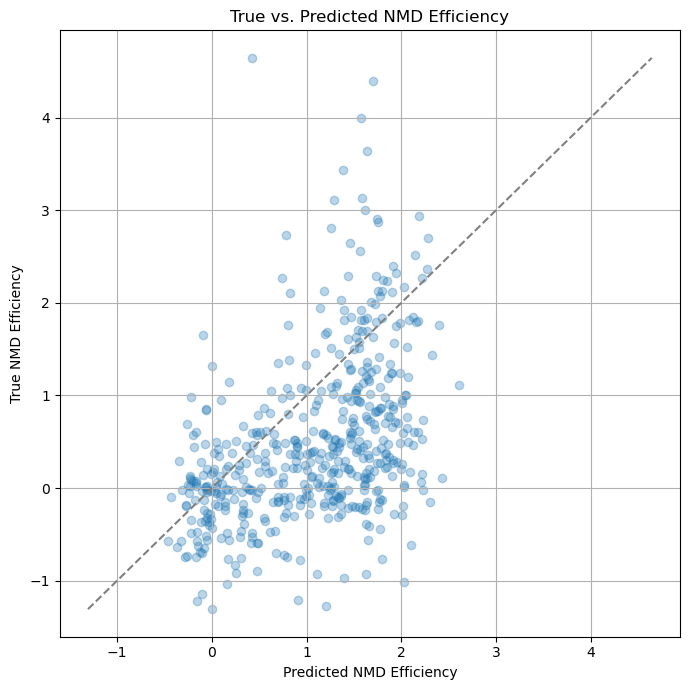

In [63]:
y_true = df_filtered['NMD_efficiency']
y_pred = regr.predict(df_filtered[cols]) # = pred

# Pearson correlation
c, p = stats.pearsonr(y_pred, y_true)
print("Pearson R:", c)
print("P-value:", p)
print("R^2:", np.square(c))

# min / max value for line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())

# Plot: True vs Predicted
plt.figure(figsize=(7, 7))
plt.scatter(y_pred, y_true, alpha=0.3)
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')
plt.ylabel("True NMD Efficiency")
plt.xlabel("Predicted NMD Efficiency")
plt.title("True vs. Predicted NMD Efficiency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
from sklearn.metrics import precision_recall_curve, average_precision_score, r2_score

r2_score(y_pred, y_true)

-0.9977980347809694

### Feature correlation

In [65]:
df_filtered.columns

Index(['transcript_id', 'variant_id', 'ref_cds_start', 'ref_cds_stop',
       'ref_cds_seq', 'ref_cds_len', 'alt_cds_start', 'alt_cds_stop',
       'alt_cds_seq', 'alt_cds_len', 'chromosome', 'gene_id', 'strand', 'ref',
       'alt', 'start_variant', 'end_variant', 'ref_cds_info', 'alt_cds_info',
       'cds_in_transcript', 'ref_start_codon_pos', 'ref_start_codon_exon',
       'ref_last_codon', 'ref_valid_stop', 'ref_first_stop_codon',
       'ref_first_stop_pos', 'ref_num_stop_codons', 'ref_all_stop_codons',
       'ref_stop_codon_exons', 'ref_is_premature', 'alt_start_codon_pos',
       'alt_start_codon_exon', 'alt_last_codon', 'alt_valid_stop',
       'alt_first_stop_codon', 'alt_first_stop_pos', 'alt_num_stop_codons',
       'alt_all_stop_codons', 'alt_stop_codon_exons', 'alt_is_premature',
       'start_loss', 'stop_loss', 'transcript_start', 'transcript_end',
       'transcript_seq', 'transcript_length', 'alt_transcript_seq',
       'alt_transcript_length', 'transcript_exon_info'

In [67]:
# Make a lookup dict from your importance_df
importance_lookup = dict(zip(importance_df["feature"], importance_df["importance"]))

def format_p_value(p):
    if p < 0.001:
        return "p < 0.001"
    else:
        return f"p = {p:.3f}"

def compute_feature_correlations(df, features, target="NMD_efficiency"):
    results = []
    for feat in features:
        x = df[feat].dropna()
        y = df.loc[x.index, target].dropna()
        if len(x) > 5:  # avoid tiny groups
            pear, p_p = pearsonr(x, y)
            spear, p_s = spearmanr(x, y)            
            results.append({
                "feature": feat,
                "pearson_r": pear,
                # "spearman_r": spear,
                "p_value": format_p_value(p_p),
                "importance": importance_lookup.get(feat, None)
            })
    return pd.DataFrame(results)

features = ["downstream_exon_count", "ptc_to_start_codon", "ptc_exon_length", "utr3_length", "ptc_to_intron", "nmd_last_exon_rule", "transcript_length", "utr5_length", "upstream_exon_count", 
            "stop_codon_distance", "nmd_50nt_penultimate_rule"]

# missing features: Dist PTC to normal stop codon (=stop_codon_distance?), LOEUF, mRNA half-life, AF, 50nt_to_last_EJ (=nmd_50nt_penultimate_rule?)

corr_df = compute_feature_correlations(df_filtered, features)
corr_df

,feature,pearson_r,p_value,importance
0,downstream_exon_count,0.034933,p = 0.433,0.117991
1,ptc_to_start_codon,-0.061351,p = 0.168,0.081546
2,ptc_exon_length,-0.247464,p < 0.001,0.101256
3,utr3_length,-0.020507,p = 0.645,0.064354
4,ptc_to_intron,-0.149659,p < 0.001,0.084140
5,nmd_last_exon_rule,-0.292018,p < 0.001,0.046169
6,transcript_length,-0.050451,p = 0.257,0.063779
7,utr5_length,0.047231,p = 0.288,0.065382
8,upstream_exon_count,-0.002277,p = 0.959,0.045193
9,stop_codon_distance,-0.060800,p = 0.172,0.095416


# Train a model for NMD Scanner on GTEx benchmark from NMD-eff

In [68]:
# merge NMD_Scanner Output von GTEx mit dem NMD_efficiency score vom Original GTEx Benchmark
# df = "~/NMD/nmd-variant-effect-prediction/resources/Output-260825/GTEx_supplementary_adj_final_nmd_results.csv" # try train on GTEx
df = "~/NMD/nmd-variant-effect-prediction/resources/Output-210925/GTEx_supplementary_adj_final_nmd_results.csv"
df2 = "~/NMD/nmd-variant-effect-prediction/resources/GTEx_benchmark/GTEx_benchmark.csv" # try train on GTEx

df = pd.read_csv(df)
df2 = pd.read_csv(df2, sep=";", header=1, decimal=",")


# 1. Remove transcript version number from NMD Scanner output (df)
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]

# 2. Adjust start_variant position (+1) to match TCGA coordinates
df['start_variant'] = df['start_variant'] + 1
#df['end_variant'] = df['end_variant'] - 1

# 3. Rename TCGA columns to match NMD Scanner
df2 = df2.rename(columns={
    'Transcript_ID': 'transcript_id',
    'start': 'start_variant',
    'end': 'end_variant'
})

# 4. Select only relevant columns from TCGA
df2_subset = df2[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']]

# 5. Merge
df_merged = pd.merge(df, df2_subset, on=['transcript_id', 'start_variant', 'end_variant'], how='inner')

print("Merged shape:", df_merged.shape)
print("Missing NMD_efficiency values:", df_merged['NMD_efficiency'].isnull().sum())
print(df_merged[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']].head())

Merged shape: (18055, 75)
Missing NMD_efficiency values: 0
     transcript_id  start_variant  end_variant  NMD_efficiency
0  ENST00000002125       37248278     37248278       -0.140177
1  ENST00000002125       37248278     37248278       -0.277535
2  ENST00000002125       37248278     37248278       -0.144391
3  ENST00000002125       37248278     37248278       -0.211503
4  ENST00000002125       37248278     37248278        0.310339


In [69]:
df_merged

,transcript_id,variant_id,ref_cds_start,ref_cds_stop,ref_cds_seq,ref_cds_len,alt_cds_start,alt_cds_stop,alt_cds_seq,alt_cds_len,...,ptc_exon_length,stop_codon_distance,ptc_to_intron,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,NMD_efficiency
0,ENST00000002125,.,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,...,1026.0,72.0,75.0,True,False,True,False,False,True,-0.140177
1,ENST00000002125,.,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,...,1026.0,72.0,75.0,True,False,True,False,False,True,-0.277535
2,ENST00000002125,.,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,...,1026.0,72.0,75.0,True,False,True,False,False,True,-0.144391
3,ENST00000002125,.,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,...,1026.0,72.0,75.0,True,False,True,False,False,True,-0.211503
4,ENST00000002125,.,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,...,1026.0,72.0,75.0,True,False,True,False,False,True,0.310339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18050,ENST00000601380,.,75611634,75671040,ATGGACCCCGCCGGGCGCGCCCGGGGCCAAGGGGCCACGGCAGGGG...,1587,75611634,75671040,ATGGACCCCGCCGGGCGCGCCCGGGGCCAAGGGGCCACGGCAGGGG...,1587,...,132.0,147.0,88.0,False,False,False,False,False,False,0.395929
18051,ENST00000602147,.,4153747,4171704,ATGAATACGGATTTAGCTGCTGGAAAGATGGCTTCTGCTGCCTGCT...,1014,4153747,4171704,ATGAATACGGATTTAGCTGCTGGAAAGATGGCTTCTGCTGCCTGCT...,1014,...,97.0,78.0,32.0,False,False,False,False,False,False,0.158156
18052,ENST00000606109,.,152759588,152761328,ATGTGTGACCAGCAGCAGATCCAGTGCCGCCTGCCGCTCCAACAGT...,1740,152759588,152761328,ATGTGTGACCAGCAGCAGATCCAGTGCCGCCTGCCGCTCCAACAGT...,1740,...,2496.0,21.0,24.0,True,False,True,False,False,True,0.273019
18053,ENST00000606109,.,152759588,152761328,ATGTGTGACCAGCAGCAGATCCAGTGCCGCCTGCCGCTCCAACAGT...,1740,152759588,152761328,ATGTGTGACCAGCAGCAGATCCAGTGCCGCCTGCCGCTCCAACAGT...,1740,...,2496.0,21.0,24.0,True,False,True,False,False,True,0.165548



--- Beschreibung von NMD_efficiency ---
count    18055.000000
mean         0.597177
std          1.431501
min         -1.000000
25%         -0.040035
50%          0.180890
75%          0.679899
max         10.000000
Name: NMD_efficiency, dtype: float64
Anzahl fehlender Werte: 0

Wertebereich: -1.000 bis 10.000


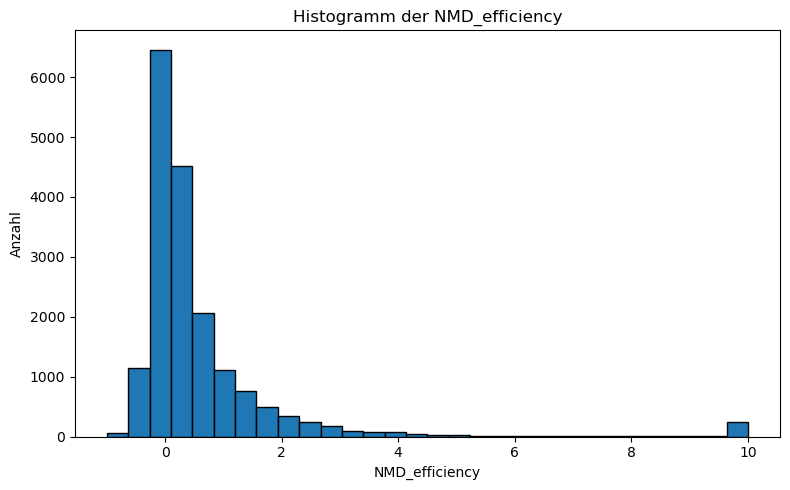

In [70]:
# 1. Beschreibung der Verteilung (inkl. NaNs)
print("\n--- Beschreibung von NMD_efficiency ---")
print(df_merged["NMD_efficiency"].describe())
print(f"Anzahl fehlender Werte: {df_merged['NMD_efficiency'].isnull().sum()}")

# 2. Wertebereich
min_eff = df_merged["NMD_efficiency"].min()
max_eff = df_merged["NMD_efficiency"].max()
print(f"\nWertebereich: {min_eff:.3f} bis {max_eff:.3f}")

# 3. Histogramm anzeigen
plt.figure(figsize=(8, 5))
df_merged["NMD_efficiency"].hist(bins=30, edgecolor='black')
plt.title("Histogramm der NMD_efficiency")
plt.xlabel("NMD_efficiency")
plt.ylabel("Anzahl")
plt.grid(False)
plt.tight_layout()
plt.show()

In [71]:
df_merged.shape

(18055, 75)

In [72]:
df_merged.columns

Index(['transcript_id', 'variant_id', 'ref_cds_start', 'ref_cds_stop',
       'ref_cds_seq', 'ref_cds_len', 'alt_cds_start', 'alt_cds_stop',
       'alt_cds_seq', 'alt_cds_len', 'chromosome', 'gene_id', 'strand', 'ref',
       'alt', 'start_variant', 'end_variant', 'ref_cds_info', 'alt_cds_info',
       'cds_in_transcript', 'ref_start_codon_pos', 'ref_start_codon_exon',
       'ref_last_codon', 'ref_valid_stop', 'ref_first_stop_codon',
       'ref_first_stop_pos', 'ref_num_stop_codons', 'ref_all_stop_codons',
       'ref_stop_codon_exons', 'ref_is_premature', 'alt_start_codon_pos',
       'alt_start_codon_exon', 'alt_last_codon', 'alt_valid_stop',
       'alt_first_stop_codon', 'alt_first_stop_pos', 'alt_num_stop_codons',
       'alt_all_stop_codons', 'alt_stop_codon_exons', 'alt_is_premature',
       'start_loss', 'stop_loss', 'transcript_start', 'transcript_end',
       'transcript_seq', 'transcript_length', 'alt_transcript_seq',
       'alt_transcript_length', 'transcript_exon_info'

In [73]:
# check if ptc_less_than_150nt_to_start == nmd_start_proximal_rule
(df_merged["ptc_less_than_150nt_to_start"] == df_merged["nmd_start_proximal_rule"]).all()

True

In [74]:
# Select the columns that we want to have as X (our features)
cols = ['start_loss', 'stop_loss', 'nmd_last_exon_rule', 'nmd_50nt_penultimate_rule', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape', # nmd escape = X or Y?
        'utr3_length', 'utr5_length', 'alt_transcript_length', 'total_exon_count', 'upstream_exon_count', 'downstream_exon_count', 'ptc_to_start_codon', 'ptc_exon_length', 'ptc_to_intron',
        'ptc_less_than_150nt_to_start', 'stop_codon_distance', 'transcript_length']

df_merged[cols].head(1)

,start_loss,stop_loss,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,utr3_length,utr5_length,alt_transcript_length,total_exon_count,upstream_exon_count,downstream_exon_count,ptc_to_start_codon,ptc_exon_length,ptc_to_intron,ptc_less_than_150nt_to_start,stop_codon_distance,transcript_length
0,False,False,True,False,True,False,False,True,810.0,48,2184.0,10,9.0,0.0,1251.0,1026.0,75.0,False,72.0,2184


In [75]:
df_merged[cols].isnull().sum()

start_loss                        0
stop_loss                         0
nmd_last_exon_rule                0
nmd_50nt_penultimate_rule         0
nmd_long_exon_rule                0
nmd_start_proximal_rule           0
nmd_single_exon_rule              0
nmd_escape                        0
utr3_length                       1
utr5_length                       0
alt_transcript_length           205
total_exon_count                  0
upstream_exon_count               0
downstream_exon_count             0
ptc_to_start_codon                7
ptc_exon_length                   0
ptc_to_intron                     0
ptc_less_than_150nt_to_start      0
stop_codon_distance             152
transcript_length                 0
dtype: int64

In [76]:
# drop non-PTCs: if alt_is_premature = False, und falls alt_is_premature = True dann darf ref_is_premature nicht True sein

# 1. remove rows with ref_is_premature = True weil dann ist Annotations-Fehler und falls alt_is_premature = True dann ist es nicht premature
df_filtered = df_merged[~df_merged["ref_is_premature"]]
rem_rows1 = df_merged.shape[0] - df_filtered.shape[0]

print(f"Rows removed in step 1 (ref_is_premature=True): {rem_rows1}")
print(f"Remaining rows: {df_filtered.shape[0]}")

# 2. remove rows with ref_is_premature = False und alt_is_premature = False
step2_rows = df_filtered.shape[0]
df_filtered = df_filtered[~((df_filtered["ref_is_premature"] == False) & (df_filtered["alt_is_premature"] == False))]
rem_rows2 = step2_rows - df_filtered.shape[0]

print(f"Rows removed in step 2 (both ref and alt not premature): {rem_rows2}")
print(f"Remaining rows: {df_filtered.shape[0]}")

df_filtered = df_filtered.reset_index(drop=True)
df_filtered.head()

Rows removed in step 1 (ref_is_premature=True): 224
Remaining rows: 17831
Rows removed in step 2 (both ref and alt not premature): 0
Remaining rows: 17831


,transcript_id,variant_id,ref_cds_start,ref_cds_stop,ref_cds_seq,ref_cds_len,alt_cds_start,alt_cds_stop,alt_cds_seq,alt_cds_len,...,ptc_exon_length,stop_codon_distance,ptc_to_intron,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,NMD_efficiency
0,ENST00000002125,.,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,...,1026.0,72.0,75.0,True,False,True,False,False,True,-0.140177
1,ENST00000002125,.,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,...,1026.0,72.0,75.0,True,False,True,False,False,True,-0.277535
2,ENST00000002125,.,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,...,1026.0,72.0,75.0,True,False,True,False,False,True,-0.144391
3,ENST00000002125,.,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,...,1026.0,72.0,75.0,True,False,True,False,False,True,-0.211503
4,ENST00000002125,.,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,37231705,37248350,ATGAGTGTACTGCTGAGGTCAGGTTTGGGGCCGTTGTGTGCCGTGG...,1326,...,1026.0,72.0,75.0,True,False,True,False,False,True,0.310339


In [77]:
df_filtered[cols].isnull().sum()

start_loss                        0
stop_loss                         0
nmd_last_exon_rule                0
nmd_50nt_penultimate_rule         0
nmd_long_exon_rule                0
nmd_start_proximal_rule           0
nmd_single_exon_rule              0
nmd_escape                        0
utr3_length                       0
utr5_length                       0
alt_transcript_length           152
total_exon_count                  0
upstream_exon_count               0
downstream_exon_count             0
ptc_to_start_codon                0
ptc_exon_length                   0
ptc_to_intron                     0
ptc_less_than_150nt_to_start      0
stop_codon_distance             152
transcript_length                 0
dtype: int64

In [78]:
# drop null values
df_filtered = df_filtered.loc[df_filtered['alt_transcript_length'].notnull()].reset_index(drop=True)
df_filtered.shape

(17679, 75)

In [79]:
df_filtered[cols].isnull().sum()

start_loss                      0
stop_loss                       0
nmd_last_exon_rule              0
nmd_50nt_penultimate_rule       0
nmd_long_exon_rule              0
nmd_start_proximal_rule         0
nmd_single_exon_rule            0
nmd_escape                      0
utr3_length                     0
utr5_length                     0
alt_transcript_length           0
total_exon_count                0
upstream_exon_count             0
downstream_exon_count           0
ptc_to_start_codon              0
ptc_exon_length                 0
ptc_to_intron                   0
ptc_less_than_150nt_to_start    0
stop_codon_distance             0
transcript_length               0
dtype: int64

In [80]:
df_filtered.shape

(17679, 75)

In [81]:
regr = RandomForestRegressor(max_features = 3, n_estimators=10000, n_jobs=-1)

In [82]:
# applying cross-valiation method for evaluation
scores = cross_val_score(regr, df_filtered[cols], df_filtered['NMD_efficiency'], cv=5)
print(f'r2: {np.mean(scores):5f}, std: {np.std(scores):5f}')

r2: 0.039340, std: 0.045517


In [83]:
X = df_filtered[cols]
y = df_filtered['NMD_efficiency']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [84]:
regr.fit(X_train, y_train)
regr.score(X_test, y_test)
print(f'r2: {regr.score(X_test, y_test):5f}')

r2: 0.692869


### Importance of trained randomforest regressor

In [85]:
importance_df = pd.DataFrame({'feature':regr.feature_names_in_, 
                              'importance': regr.feature_importances_})

importance_df = importance_df.sort_values(by="importance", ascending=False).reset_index(drop=True)
importance_df 

,feature,importance
0,ptc_exon_length,0.109075
1,utr5_length,0.100674
2,transcript_length,0.099974
3,alt_transcript_length,0.099537
4,stop_codon_distance,0.097360
5,ptc_to_start_codon,0.091084
6,utr3_length,0.083881
7,ptc_to_intron,0.080346
8,downstream_exon_count,0.069154
9,total_exon_count,0.056327


In [86]:
# Save the trained model
pickle.dump(regr, open('nmd_eff_predictor_gtex', 'wb'))

### Prediction

In [87]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.ensemble import RandomForestRegressor

In [90]:
# merge NMD_Scanner Output von MMRF mit dem NMD_efficiency score vom Original TCGA Benchmark
# df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/Output-260825/MMRF_TARGET_dataset_final_nmd_results.csv')
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/Output-210925/MMRF_TARGET_dataset_final_nmd_results.csv')
df2 = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/MMRF_benchmark/MMRF_TARGET_dataset.csv')

# 1. Remove transcript version number from NMD Scanner output (df)
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]

# 2. Adjust start_variant position (+1) to match TCGA coordinates
df['start_variant'] = df['start_variant'] + 1
#df['end_variant'] = df['end_variant'] - 1

# 3. Rename TCGA columns to match NMD Scanner
df2 = df2.rename(columns={
    'Transcript_ID': 'transcript_id',
    'start': 'start_variant'
})

# 4. Select only relevant columns from TCGA
df2_subset = df2[['transcript_id', 'start_variant', 'NMD_efficiency']]

# 5. Merge
df_merged = pd.merge(df, df2_subset, on=['transcript_id', 'start_variant'], how='inner')

# ✅ Inspect result
print("Merged shape:", df_merged.shape)
print("Missing NMD_efficiency values:", df_merged['NMD_efficiency'].isnull().sum())
print(df_merged[['transcript_id', 'start_variant', 'NMD_efficiency']].head())

Merged shape: (549, 75)
Missing NMD_efficiency values: 0
     transcript_id  start_variant  NMD_efficiency
0  ENST00000038176       58609624        0.710493
1  ENST00000040738       13576985        0.022368
2  ENST00000155093        2979509       -0.019109
3  ENST00000156471       34857043        0.040062
4  ENST00000202917      112917610        0.987014


In [91]:
df_merged.columns

Index(['transcript_id', 'variant_id', 'ref_cds_start', 'ref_cds_stop',
       'ref_cds_seq', 'ref_cds_len', 'alt_cds_start', 'alt_cds_stop',
       'alt_cds_seq', 'alt_cds_len', 'chromosome', 'gene_id', 'strand', 'ref',
       'alt', 'start_variant', 'end_variant', 'ref_cds_info', 'alt_cds_info',
       'cds_in_transcript', 'ref_start_codon_pos', 'ref_start_codon_exon',
       'ref_last_codon', 'ref_valid_stop', 'ref_first_stop_codon',
       'ref_first_stop_pos', 'ref_num_stop_codons', 'ref_all_stop_codons',
       'ref_stop_codon_exons', 'ref_is_premature', 'alt_start_codon_pos',
       'alt_start_codon_exon', 'alt_last_codon', 'alt_valid_stop',
       'alt_first_stop_codon', 'alt_first_stop_pos', 'alt_num_stop_codons',
       'alt_all_stop_codons', 'alt_stop_codon_exons', 'alt_is_premature',
       'start_loss', 'stop_loss', 'transcript_start', 'transcript_end',
       'transcript_seq', 'transcript_length', 'alt_transcript_seq',
       'alt_transcript_length', 'transcript_exon_info'

In [92]:
# Select the columns that we want to have as X (our features)
cols = ['start_loss', 'stop_loss', 'nmd_last_exon_rule', 'nmd_50nt_penultimate_rule', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape', # nmd escape = X or Y?
        'utr3_length', 'utr5_length', 'alt_transcript_length', 'total_exon_count', 'upstream_exon_count', 'downstream_exon_count', 'ptc_to_start_codon', 'ptc_exon_length', 'ptc_to_intron',
        'ptc_less_than_150nt_to_start', 'stop_codon_distance', 'transcript_length']

df_merged[cols].head(1)

,start_loss,stop_loss,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,utr3_length,utr5_length,alt_transcript_length,total_exon_count,upstream_exon_count,downstream_exon_count,ptc_to_start_codon,ptc_exon_length,ptc_to_intron,ptc_less_than_150nt_to_start,stop_codon_distance,transcript_length
0,False,False,False,False,False,False,False,False,222.0,598,3574.0,31,9.0,21.0,666.0,130.0,21.0,False,2085.0,3574


In [93]:
df_merged[cols].isnull().sum()

start_loss                       0
stop_loss                        0
nmd_last_exon_rule               0
nmd_50nt_penultimate_rule        0
nmd_long_exon_rule               0
nmd_start_proximal_rule          0
nmd_single_exon_rule             0
nmd_escape                       0
utr3_length                     10
utr5_length                      0
alt_transcript_length           39
total_exon_count                 0
upstream_exon_count              1
downstream_exon_count            1
ptc_to_start_codon              11
ptc_exon_length                  1
ptc_to_intron                    1
ptc_less_than_150nt_to_start     0
stop_codon_distance             39
transcript_length                0
dtype: int64

In [94]:
# drop non-PTCs: if alt_is_premature = False, und falls alt_is_premature = True dann darf ref_is_premature nicht True sein

# 1. remove rows with ref_is_premature = True weil dann ist Annotations-Fehler und falls alt_is_premature = True dann ist es nicht premature
df_filtered = df_merged[~df_merged["ref_is_premature"]]
rem_rows1 = df_merged.shape[0] - df_filtered.shape[0]

print(f"Rows removed in step 1 (ref_is_premature=True): {rem_rows1}")
print(f"Remaining rows: {df_filtered.shape[0]}")

# 2. remove rows with ref_is_premature = False und alt_is_premature = False
step2_rows = df_filtered.shape[0]
df_filtered = df_filtered[~((df_filtered["ref_is_premature"] == False) & (df_filtered["alt_is_premature"] == False))]
rem_rows2 = step2_rows - df_filtered.shape[0]

print(f"Rows removed in step 2 (both ref and alt not premature): {rem_rows2}")
print(f"Remaining rows: {df_filtered.shape[0]}")

df_filtered = df_filtered.reset_index(drop=True)
df_filtered.head()

Rows removed in step 1 (ref_is_premature=True): 1
Remaining rows: 548
Rows removed in step 2 (both ref and alt not premature): 1
Remaining rows: 547


,transcript_id,variant_id,ref_cds_start,ref_cds_stop,ref_cds_seq,ref_cds_len,alt_cds_start,alt_cds_stop,alt_cds_seq,alt_cds_len,...,ptc_exon_length,stop_codon_distance,ptc_to_intron,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,NMD_efficiency
0,ENST00000038176,.,58584105,58659631,ATGGCGTTTATCCGGAAGAAGCAGCAGGAGCAGCAGCTGCAGCTCT...,2754,58584105,58659631,ATGGCGTTTATCCGGAAGAAGCAGCAGGAGCAGCAGCTGCAGCTCT...,2754,...,130.0,2085.0,21.0,False,False,False,False,False,False,0.710493
1,ENST00000040738,.,13570010,13627587,ATGGCCACCAACCCACAGCCGCAGCCGCCTCCTCCGGCGCCGCCGC...,9156,13570010,13627587,ATGGCCACCAACCCACAGCCGCAGCCGCCTCCTCCGGCGCCGCCGC...,9156,...,154.0,264.0,149.0,False,False,False,False,False,False,0.022368
2,ENST00000155093,.,2953936,2979993,ATGGATGAAGATGAATTTGAATTGCAGCCACAAGAGCCAAACTCAT...,2406,2953936,2979993,ATGGATGAAGATGAATTTGAATTGCAGCCACAAGAGCCAAACTCAT...,2406,...,3697.0,483.0,486.0,True,False,True,False,False,True,-0.019109
3,ENST00000156471,.,34856791,34969613,ATGGCAGCCCCTGCGCAGCCCAAGAAGATCGTGGCCCCTACGGTGT...,4458,34856791,34969613,ATGGCAGCCCCTGCGCAGCCCAAGAAGATCGTGGCCCCTACGGTGT...,4458,...,5325.0,249.0,252.0,True,False,True,False,False,True,0.040062
4,ENST00000202917,.,112907039,112919553,ATGATGGATCTCAGAAATACCCCAGCCAAATCTCTGGACAAGTTCA...,1203,112907039,112919553,ATGATGGATCTCAGAAATACCCCAGCCAAATCTCTGGACAAGTTCA...,1203,...,154.0,255.0,93.0,False,False,False,False,False,False,0.987014


In [95]:
df_filtered[cols].isnull().sum()

start_loss                       0
stop_loss                        0
nmd_last_exon_rule               0
nmd_50nt_penultimate_rule        0
nmd_long_exon_rule               0
nmd_start_proximal_rule          0
nmd_single_exon_rule             0
nmd_escape                       0
utr3_length                      9
utr5_length                      0
alt_transcript_length           38
total_exon_count                 0
upstream_exon_count              0
downstream_exon_count            0
ptc_to_start_codon              10
ptc_exon_length                  0
ptc_to_intron                    0
ptc_less_than_150nt_to_start     0
stop_codon_distance             38
transcript_length                0
dtype: int64

In [96]:
# drop null values
df_filtered = df_filtered.loc[df_filtered['alt_transcript_length'].notnull()].reset_index(drop=True)
df_filtered = df_filtered.loc[df_filtered['ptc_to_start_codon'].notnull()].reset_index(drop=True)
df.shape

(2452, 74)

In [97]:
df_filtered[cols].isnull().sum()

start_loss                      0
stop_loss                       0
nmd_last_exon_rule              0
nmd_50nt_penultimate_rule       0
nmd_long_exon_rule              0
nmd_start_proximal_rule         0
nmd_single_exon_rule            0
nmd_escape                      0
utr3_length                     0
utr5_length                     0
alt_transcript_length           0
total_exon_count                0
upstream_exon_count             0
downstream_exon_count           0
ptc_to_start_codon              0
ptc_exon_length                 0
ptc_to_intron                   0
ptc_less_than_150nt_to_start    0
stop_codon_distance             0
transcript_length               0
dtype: int64

In [98]:
regr = pickle.load(open('./nmd_eff_predictor_gtex', 'rb'))

def predict_NMD_efficiency(start_loss:bool, stop_loss:bool, nmd_last_exon_rule:bool, nmd_50nt_penultimate_rule:bool, 
                           nmd_long_exon_rule:bool, nmd_start_proximal_rule:bool, nmd_single_exon_rule:bool, nmd_escape:bool,
                           utr3_length:int, utr5_length:int, alt_transcript_length:float, total_exon_count:float, 
                           upstream_exon_count:float, downstream_exon_count:float, ptc_to_start_codon:float, ptc_exon_length:float,
                           stop_codon_distance:float):
    
    input_value =[[start_loss, stop_loss, nmd_last_exon_rule, nmd_50nt_penultimate_rule, nmd_long_exon_rule, nmd_start_proximal_rule, 
                   nmd_single_exon_rule, nmd_escape, utr3_length, utr5_length, alt_transcript_length, total_exon_count, 
                   upstream_exon_count, downstream_exon_count, ptc_to_start_codon, ptc_exon_length, stop_codon_distance]]
    
    assert sum([np.isnan(value) for value in input_value[0]]) == 0, 'Replace NaN value'
    
    pred = regr.predict(input_value)[0]
    
    return pred


def predict_NMD_efficiency_df(examples):
    df_merged = pd.DataFrame(examples)

    assert df_merged.isnull().sum().sum() == 0, 'Replace NaN value'

    pred = regr.predict(df_merged)

    return pred

In [99]:
pred = regr.predict(df_filtered[cols])
c, p = stats.pearsonr(pred, df_filtered['NMD_efficiency'])
print("Pearson R :" , c)
print("P-value : " , p)

Pearson R : 0.30293679173155896
P-value :  3.19884220323195e-12


Pearson R: 0.30293679173155896
P-value: 3.19884220323195e-12
R^2: 0.09177069978460993


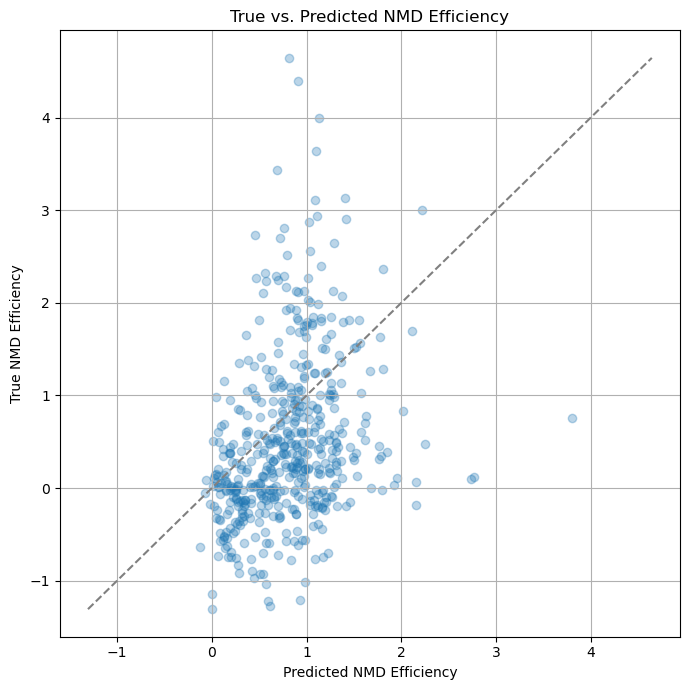

In [100]:
y_true = df_filtered['NMD_efficiency']
y_pred = regr.predict(df_filtered[cols]) # = pred

# Pearson correlation
c, p = stats.pearsonr(y_pred, y_true)
print("Pearson R:", c)
print("P-value:", p)
print("R^2:", np.square(c))

# min / max value for line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())

# Plot: True vs Predicted
plt.figure(figsize=(7, 7))
plt.scatter(y_pred, y_true, alpha=0.3)
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')
plt.ylabel("True NMD Efficiency")
plt.xlabel("Predicted NMD Efficiency")
plt.title("True vs. Predicted NMD Efficiency")
plt.grid(True)
plt.tight_layout()
plt.show()

### Feature correlation

In [101]:
df_filtered.columns

Index(['transcript_id', 'variant_id', 'ref_cds_start', 'ref_cds_stop',
       'ref_cds_seq', 'ref_cds_len', 'alt_cds_start', 'alt_cds_stop',
       'alt_cds_seq', 'alt_cds_len', 'chromosome', 'gene_id', 'strand', 'ref',
       'alt', 'start_variant', 'end_variant', 'ref_cds_info', 'alt_cds_info',
       'cds_in_transcript', 'ref_start_codon_pos', 'ref_start_codon_exon',
       'ref_last_codon', 'ref_valid_stop', 'ref_first_stop_codon',
       'ref_first_stop_pos', 'ref_num_stop_codons', 'ref_all_stop_codons',
       'ref_stop_codon_exons', 'ref_is_premature', 'alt_start_codon_pos',
       'alt_start_codon_exon', 'alt_last_codon', 'alt_valid_stop',
       'alt_first_stop_codon', 'alt_first_stop_pos', 'alt_num_stop_codons',
       'alt_all_stop_codons', 'alt_stop_codon_exons', 'alt_is_premature',
       'start_loss', 'stop_loss', 'transcript_start', 'transcript_end',
       'transcript_seq', 'transcript_length', 'alt_transcript_seq',
       'alt_transcript_length', 'transcript_exon_info'

In [103]:
# Make a lookup dict from your importance_df
importance_lookup = dict(zip(importance_df["feature"], importance_df["importance"]))

def format_p_value(p):
    if p < 0.001:
        return "p < 0.001"
    else:
        return f"p = {p:.3f}"

def compute_feature_correlations(df, features, target="NMD_efficiency"):
    results = []
    for feat in features:
        x = df[feat].dropna()
        y = df.loc[x.index, target].dropna()
        if len(x) > 5:  # avoid tiny groups
            pear, p_p = pearsonr(x, y)
            spear, p_s = spearmanr(x, y)            
            results.append({
                "feature": feat,
                "pearson_r": pear,
                # "spearman_r": spear,
                "p_value": format_p_value(p_p),
                "importance": importance_lookup.get(feat, None)
            })
    return pd.DataFrame(results)

features = ["downstream_exon_count", "ptc_to_start_codon", "ptc_exon_length", "utr3_length", "ptc_to_intron", "nmd_last_exon_rule", "transcript_length", "utr5_length", "upstream_exon_count", 
           "stop_codon_distance", "ptc_to_intron"]
# missing features: Dist PTC to normal stop codon, LOEUF, mRNA half-life, AF, 50nt_to_last_EJ

corr_df = compute_feature_correlations(df_filtered, features)
corr_df

,feature,pearson_r,p_value,importance
0,downstream_exon_count,0.034933,p = 0.433,0.069154
1,ptc_to_start_codon,-0.061351,p = 0.168,0.091084
2,ptc_exon_length,-0.247464,p < 0.001,0.109075
3,utr3_length,-0.020507,p = 0.645,0.083881
4,ptc_to_intron,-0.149659,p < 0.001,0.080346
5,nmd_last_exon_rule,-0.292018,p < 0.001,0.017062
6,transcript_length,-0.050451,p = 0.257,0.099974
7,utr5_length,0.047231,p = 0.288,0.100674
8,upstream_exon_count,-0.002277,p = 0.959,0.052101
9,stop_codon_distance,-0.060800,p = 0.172,0.097360


# XX: Create Model on new Output

In [2]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/data/nasif12/modules_if12/SL7/i12g/anaconda/envs/florian4/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(


In [4]:
# merge NMD_Scanner Output von TCGA mit dem NMD_efficiency score vom Original TCGA Benchmark
# df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/Output/tcga_dataset_final_nmd_results.csv')
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/Output-210925/tcga_dataset_final_nmd_results.csv')
df2 = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset.csv')


# 1. Remove transcript version number from NMD Scanner output (df)
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]

# 2. Adjust start_variant position (+1) to match TCGA coordinates
df['start_variant'] = df['start_variant'] + 1
#df['end_variant'] = df['end_variant'] - 1

# 3. Rename TCGA columns to match NMD Scanner
df2 = df2.rename(columns={
    'Transcript_ID': 'transcript_id',
    'start': 'start_variant',
    'end': 'end_variant'
})

# 4. Select only relevant columns from TCGA
df2_subset = df2[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']]

# 5. Merge
df_merged = pd.merge(df, df2_subset, on=['transcript_id', 'start_variant', 'end_variant'], how='inner')

# 6. Select the columns that we want to have as X (our features)
#cols = ['start_loss', 'stop_loss', 'nmd_last_exon_rule', 'nmd_50nt_penultimate_rule', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape', # nmd escape = X or Y?
#        'utr3_length', 'utr5_length', 'alt_transcript_length', 'total_exon_count', 'upstream_exon_count', 'downstream_exon_count', 'ptc_to_start_codon', 'ptc_exon_length', 
#        'stop_codon_distance']

# new features:
cols = ['start_loss', 'stop_loss', 'total_exon_count', 'ptc_less_than_150nt_to_start', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape',
        'downstream_exon_count', 'nmd_last_exon_rule', 'ptc_to_start_codon', 
        'stop_codon_distance', 'ptc_exon_length', 'ptc_to_intron', 'upstream_exon_count', 
        'nmd_50nt_penultimate_rule', 'utr5_length' ,'utr3_length', 'transcript_length']

X = df_merged[cols]
y = df_merged['NMD_efficiency']

print("Merged shape:", df_merged.shape)
print("Missing NMD_efficiency values:", df_merged['NMD_efficiency'].isnull().sum())
print(df_merged[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']].head())

Merged shape: (4246, 75)
Missing NMD_efficiency values: 0
     transcript_id  start_variant  end_variant  NMD_efficiency
0  ENST00000000412        8942472      8942472        0.389934
1  ENST00000000442       64314869     64314869        0.425091
2  ENST00000002165      143497446    143497446        1.165452
3  ENST00000002829       50174085     50174085        1.631418
4  ENST00000003084      117627525    117627525        0.999051


In [5]:
df_merged[cols].isnull().sum()

start_loss                       0
stop_loss                        0
total_exon_count                 0
ptc_less_than_150nt_to_start     0
nmd_long_exon_rule               0
nmd_start_proximal_rule          0
nmd_single_exon_rule             0
nmd_escape                       0
downstream_exon_count            0
nmd_last_exon_rule               0
ptc_to_start_codon               3
stop_codon_distance             10
ptc_exon_length                  0
ptc_to_intron                    0
upstream_exon_count              0
nmd_50nt_penultimate_rule        0
utr5_length                      0
utr3_length                      0
transcript_length                0
dtype: int64

In [6]:
# show rows with nulls in it
pd.set_option('display.max_columns', None)
null_rows = df_merged[df_merged[cols].isnull().any(axis=1)]
null_rows

,transcript_id,variant_id,ref_cds_start,ref_cds_stop,ref_cds_seq,ref_cds_len,alt_cds_start,alt_cds_stop,alt_cds_seq,alt_cds_len,chromosome,gene_id,strand,ref,alt,start_variant,end_variant,ref_cds_info,alt_cds_info,cds_in_transcript,ref_start_codon_pos,ref_start_codon_exon,ref_last_codon,ref_valid_stop,ref_first_stop_codon,ref_first_stop_pos,ref_num_stop_codons,ref_all_stop_codons,ref_stop_codon_exons,ref_is_premature,alt_start_codon_pos,alt_start_codon_exon,alt_last_codon,alt_valid_stop,alt_first_stop_codon,alt_first_stop_pos,alt_num_stop_codons,alt_all_stop_codons,alt_stop_codon_exons,alt_is_premature,start_loss,stop_loss,transcript_start,transcript_end,transcript_seq,transcript_length,alt_transcript_seq,alt_transcript_length,transcript_exon_info,transcript_start_codon_pos,transcript_start_codon_exon,transcript_last_codon,transcript_valid_stop,transcript_first_stop_codon,transcript_first_stop_pos,transcript_num_stop_codons,transcript_all_stop_codons,transcript_stop_codon_exons,utr3_length,utr5_length,total_exon_count,upstream_exon_count,downstream_exon_count,ptc_to_start_codon,ptc_less_than_150nt_to_start,ptc_exon_length,stop_codon_distance,ptc_to_intron,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,NMD_efficiency
496,ENST00000252934,.,45672063,45843181,ATGGCGGCGCCCAGGCCGCCGCCTGCCAGGCTGTCGGGCGTCATGG...,1428,45672063,45843181,ATGGCGGCGCCCAGGCCGCCGCCTGCCAGGCTGTCGGGCGTCATGG...,1428,chr22,ENSG00000130638.17,+,C,T,45738806,45738806,"[(1, 116), (2, 192), (3, 83), (4, 97), (5, 159...","[(1, 116), (2, 192), (3, 83), (4, 97), (5, 159...",False,0.0,1.0,GTA,False,NaN,NaN,0,[],[],False,0.0,1.0,GTA,False,TAG,969.0,1,"[(969, 'TAG')]",[8],True,False,False,45671833,45845307,GCCGTCTCCTCCTCCCGCCTGAGGCGAGTCTGGGCTCAGCCTAGAG...,3294,NaN,NaN,"[('1', 346), ('2', 192), ('3', 83), ('4', 97),...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1639,230,12,7.0,4.0,969.0,False,109.0,NaN,34.0,False,False,False,False,False,False,2.740168
497,ENST00000252934,.,45672063,45843181,ATGGCGGCGCCCAGGCCGCCGCCTGCCAGGCTGTCGGGCGTCATGG...,1428,45672063,45843181,ATGGCGGCGCCCAGGCCGCCGCCTGCCAGGCTGTCGGGCGTCATGG...,1428,chr22,ENSG00000130638.17,+,G,T,45740401,45740401,"[(1, 116), (2, 192), (3, 83), (4, 97), (5, 159...","[(1, 116), (2, 192), (3, 83), (4, 97), (5, 159...",False,0.0,1.0,GTA,False,NaN,NaN,0,[],[],False,0.0,1.0,GTA,False,TAA,1035.0,1,"[(1035, 'TAA')]",[9],True,False,False,45671833,45845307,GCCGTCTCCTCCTCCCGCCTGAGGCGAGTCTGGGCTCAGCCTAGAG...,3294,NaN,NaN,"[('1', 346), ('2', 192), ('3', 83), ('4', 97),...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1639,230,12,8.0,3.0,1035.0,False,170.0,NaN,138.0,False,False,False,False,False,False,2.538866
574,ENST00000257745,.,105040952,105089364,ATGAGCATAGTGATCCCATTGGGGGTTGATACAGCAGAGACGTCAT...,1497,105040952,105089364,ATGAGCATAGTGATCCCATTGGGGGTTGATACAGCAGAGACGTCAT...,1497,chr7,ENSG00000005483.22,+,T,A,105081732,105081732,"[(2, 71), (3, 115), (4, 230), (5, 81), (6, 59)...","[(2, 71), (3, 115), (4, 230), (5, 81), (6, 59)...",False,0.0,2.0,GTA,False,NaN,NaN,0,[],[],False,0.0,2.0,GTA,False,TAA,1290.0,1,"[(1290, 'TAA')]",[12],True,False,False,105014163,105112658,GCCGCCGCCGCGGCCGCCGCCGCCGCCGCCGCCATTTTCCCAGAGC...,5524,NaN,NaN,"[('1', 372), ('2', 185), ('3', 115), ('4', 230...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3544,486,27,11.0,15.0,1290.0,False,110.0,NaN,68.0,False,False,False,False,False,False,1.028569
972,ENST00000265827,.,127373340,127391557,ATGCCTTTAAGGGACAAATACTGTCAGACTGACCACCATCATCACG...,1995,127373340,127391557,ATGCCTTTAAGGGACAAATACTGTCAGACTGACCACCATCATCACG...,1995,chr7,ENSG00000048405.11,-,C,A,127374954,127374954,"[(2, 61), (3, 96), (4, 144), (5, 1694)]","[(2, 61), (3, 96), (4, 144), (5, 1694)]",False,0.0,2.0,TGG,False,NaN,NaN,0,[],[],False,0.0,2.0,TGG,False,TAA,381.0,1,"[(381, 'TAA')]",[5],True,False,False,127370042,127392708,AGTCAGTCGCTCCCTGTCGCTGCCGGAGAGTCTCTGCTTCCCCCTT...,4473,NaN,NaN,"[('1', 649), ('2', 119), ('3', 96), ('4', 144)...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [7]:
cell_value = null_rows.loc[null_rows["transcript_id"] == "ENST00000265827", "ref_cds_seq"].iloc[0]
print(cell_value)

ATGCCTTTAAGGGACAAATACTGTCAGACTGACCACCATCATCACGGATGCTGTGAACCAGTTTATATCCTGGAACCTGGAGATCCTCCTTTGTTACAGCAACCACTACAGACATCCAAATCTGGTATTCAACAAATAATTGAGTGCTTTCGATCAGGAACTAAACAACTTAAGCATATTTTATTAAAAGATGTGGACACTATTTTTGAATGTAAGTTATGCCGCAGTCTCTTCAGAGGATTACCAAATTTAATTACCCATAAAAAATTCTACTGCCCACCAAGTCTCCAGATGGATGACAACCTTCCTGATGTAAATGATAAACAAAGCCAAGCCATAAATGATCTCCTAGAAGCCATATATCCAAGTGTGGACAAACGAGAATATATTATTAAGCTAGAACCCATAGAAACTAATCAAAATGCAGTATTTCAATATATTTCGAGGACTGATAATCCTATTGAAGTCACAGAGTCAAGCAGTACTCCTGAACAAACCGAAGTTCAGATACAGGAAACTAGCACTGAACAGTCAAAAACAGTACCGGTTACAGATACAGAGGTGGAAACTGTAGAGCCCCCTCCTGTTGAGATTGTTACAGATGAAGTTGCACCTACATCTGATGAACAACCTCAGGAGTCGCAGGCTGACTTGGAAACTTCTGACAATTCTGATTTTGGTCACCAGTTGATATGTTGTCTTTGTAGAAAAGAATTCAATTCTAGACGAGGTGTTCGCCGTCACATTCGAAAAGTACACAAGAAAAAGATGGAAGAACTAAAAAAGTACATTGAAACACGAAAGAATCCAAACCAATCCTCTAAAGGACGCAGTAAGAATGTTCTAGTTCCATTAAGTAGGAGTTGTCCAGTATGTTGTAAATCATTTGCTACAAAAGCGAATGTAAGGAGGCATTTTGATGAAGTTCATAGAGGACTAAGGAGGGATTCAATTACTCCTGATATAGCAACAAAGCCTGGGCAACCTTTGTTCCTGGATT

In [8]:
# drop non-PTCs: if alt_is_premature = False, und falls alt_is_premature = True dann darf ref_is_premature nicht True sein

# 1. remove rows with ref_is_premature = True weil dann ist Annotations-Fehler und falls alt_is_premature = True dann ist es nicht premature
df_filtered = df_merged[~df_merged["ref_is_premature"]]
rem_rows1 = df_merged.shape[0] - df_filtered.shape[0]

print(f"Rows removed in step 1 (ref_is_premature=True): {rem_rows1}")
print(f"Remaining rows: {df_filtered.shape[0]}")

# 2. remove rows with ref_is_premature = False und alt_is_premature = False
step2_rows = df_filtered.shape[0]
df_filtered = df_filtered[~((df_filtered["ref_is_premature"] == False) & (df_filtered["alt_is_premature"] == False))]
rem_rows2 = step2_rows - df_filtered.shape[0]

print(f"Rows removed in step 2 (both ref and alt not premature): {rem_rows2}")
print(f"Remaining rows: {df_filtered.shape[0]}")

df_filtered = df_filtered.reset_index(drop=True)
df_filtered.head()

Rows removed in step 1 (ref_is_premature=True): 6
Remaining rows: 4240
Rows removed in step 2 (both ref and alt not premature): 0
Remaining rows: 4240


,transcript_id,variant_id,ref_cds_start,ref_cds_stop,ref_cds_seq,ref_cds_len,alt_cds_start,alt_cds_stop,alt_cds_seq,alt_cds_len,chromosome,gene_id,strand,ref,alt,start_variant,end_variant,ref_cds_info,alt_cds_info,cds_in_transcript,ref_start_codon_pos,ref_start_codon_exon,ref_last_codon,ref_valid_stop,ref_first_stop_codon,ref_first_stop_pos,ref_num_stop_codons,ref_all_stop_codons,ref_stop_codon_exons,ref_is_premature,alt_start_codon_pos,alt_start_codon_exon,alt_last_codon,alt_valid_stop,alt_first_stop_codon,alt_first_stop_pos,alt_num_stop_codons,alt_all_stop_codons,alt_stop_codon_exons,alt_is_premature,start_loss,stop_loss,transcript_start,transcript_end,transcript_seq,transcript_length,alt_transcript_seq,alt_transcript_length,transcript_exon_info,transcript_start_codon_pos,transcript_start_codon_exon,transcript_last_codon,transcript_valid_stop,transcript_first_stop_codon,transcript_first_stop_pos,transcript_num_stop_codons,transcript_all_stop_codons,transcript_stop_codon_exons,utr3_length,utr5_length,total_exon_count,upstream_exon_count,downstream_exon_count,ptc_to_start_codon,ptc_less_than_150nt_to_start,ptc_exon_length,stop_codon_distance,ptc_to_intron,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,NMD_efficiency
0,ENST00000000412,.,8941817,8946404,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,834,8941817,8946404,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,834,chr12,ENSG00000003056.8,-,C,A,8942472,8942472,"[(2, 176), (3, 167), (4, 110), (5, 131), (6, 1...","[(2, 176), (3, 167), (4, 110), (5, 131), (6, 1...",True,0.0,2.0,TAG,True,TAG,831.0,1,"[(831, 'TAG')]",[7],False,0.0,2.0,TAG,True,TGA,654.0,2,"[(654, 'TGA'), (831, 'TAG')]","[6, 7]",True,False,False,8940360,8949645,AGAGTGGGGCACAGCGAGGCGCTAGGGGGAACGCTGGCCTCTGAAA...,2450,AGAGTGGGGCACAGCGAGGCGCTAGGGGGAACGCTGGCCTCTGAAA...,2450.0,"[('1', 158), ('2', 177), ('3', 167), ('4', 110...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159,1457,7,5.0,1.0,654.0,False,127.0,177.0,57.0,False,False,False,False,False,False,0.389934
1,ENST00000000442,.,64307179,64315966,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,1272,64307179,64315966,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,1272,chr11,ENSG00000173153.17,+,C,T,64314869,64314869,"[(2, 325), (3, 117), (4, 129), (5, 171), (6, 2...","[(2, 325), (3, 117), (4, 129), (5, 171), (6, 2...",True,0.0,2.0,TGA,True,TGA,1269.0,1,"[(1269, 'TGA')]",[7],False,0.0,2.0,TGA,True,TGA,699.0,2,"[(699, 'TGA'), (1269, 'TGA')]","[5, 7]",True,False,False,64305523,64316743,GTCAGCTGGAGGAAGCGGAGTAGGAAGCGGCCGCGATGTCCTTTTG...,2274,GTCAGCTGGAGGAAGCGGAGTAGGAAGCGGCCGCGATGTCCTTTTG...,2274.0,"[('1', 213), ('2', 337), ('3', 117), ('4', 129...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777,225,7,4.0,2.0,699.0,False,171.0,570.0,43.0,False,False,False,False,False,False,0.425091
2,ENST00000002165,.,143495706,143511634,ATGCGGCCCCAGGAGCTCCCCAGGCTCGCGTTCCCGTTGCTGCTGT...,1404,143495706,143511634,ATGCGGCCCCAGGAGCTCCCCAGGCTCGCGTTCCCGTTGCTGCTGT...,1404,chr6,ENSG00000001036.14,-,C,T,143497446,143497446,"[(1, 224), (2, 188), (3, 340), (4, 211), (5, 1...","[(1, 224), (2, 188), (3, 340), (4, 211), (5, 1...",True,0.0,1.0,TAA,True,TAA,1401.0,1,"[(1401, 'TAA')]",[7],False,0.0,1.0,TAA,True,TGA,1203.0,2,"[(1203, 'TGA'), (1401, 'TAA')]","[6, 7]",True,False,False,143494811,143511720,GCGGCATACTCAGCGGCAGAGACGGAAGAACAGCGCTCCCGAGGCC...,2385,GCGGCATACTCAGCGGCAGAGACGGAAGAACAGCGCTCCCGAGGCC...,2385.0,"[('1', 310), ('2', 188), ('3', 340), ('4', 211...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86,895,7,5.0,1.0,1203.0,False,109.0,198.0,60.0,False,False,False,False,False,False,1.165452
3,ENST00000002829,.,50159622,50188115,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,2358,50159622,50188115,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,2358,chr3,ENSG00000001617.12,+,G,T,50174085,50174085,"[(2, 112), (3, 161), (4, 63), (5, 120), (6, 93...","[(2, 112), (3, 161), (4, 63), (5, 120), (6, 93...",True,0.0,2.0,TGA,True,TGA,2355.0,1,"[(23

In [9]:
df_filtered[cols].isnull().sum()

start_loss                       0
stop_loss                        0
total_exon_count                 0
ptc_less_than_150nt_to_start     0
nmd_long_exon_rule               0
nmd_start_proximal_rule          0
nmd_single_exon_rule             0
nmd_escape                       0
downstream_exon_count            0
nmd_last_exon_rule               0
ptc_to_start_codon               1
stop_codon_distance             10
ptc_exon_length                  0
ptc_to_intron                    0
upstream_exon_count              0
nmd_50nt_penultimate_rule        0
utr5_length                      0
utr3_length                      0
transcript_length                0
dtype: int64

In [10]:
# drop null values
df_filtered = df_filtered.loc[df_filtered['stop_codon_distance'].notnull()].reset_index(drop=True)
df_filtered = df_filtered.loc[df_filtered['ptc_to_start_codon'].notnull()].reset_index(drop=True)
df_filtered.shape

(4229, 75)

In [11]:
df_filtered[cols].isnull().sum()

start_loss                      0
stop_loss                       0
total_exon_count                0
ptc_less_than_150nt_to_start    0
nmd_long_exon_rule              0
nmd_start_proximal_rule         0
nmd_single_exon_rule            0
nmd_escape                      0
downstream_exon_count           0
nmd_last_exon_rule              0
ptc_to_start_codon              0
stop_codon_distance             0
ptc_exon_length                 0
ptc_to_intron                   0
upstream_exon_count             0
nmd_50nt_penultimate_rule       0
utr5_length                     0
utr3_length                     0
transcript_length               0
dtype: int64

In [12]:
# Define X and y from your earlier code
X = df_filtered[cols]
y = df_filtered['NMD_efficiency']

In [13]:
# Try different models --> some accept NaNs some not
models = {
    "Random Forest": RandomForestRegressor(n_estimators=500, max_features=3),
    "XGBoost": xgb.XGBRegressor(n_estimators=500, learning_rate=0.05),
    "LightGBM": LGBMRegressor(n_estimators=500),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=500),
    "Ridge": Ridge(),
    "Lasso": Lasso(alpha=0.01),
    "SVR": SVR()
}

print("Model Comparison (5-fold CV, R² Scores):")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"{name:15s} | R²: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

Model Comparison (5-fold CV, R² Scores):
Random Forest   | R²: 0.3905 ± 0.0325
XGBoost         | R²: 0.3382 ± 0.0340
LightGBM        | R²: 0.3051 ± 0.0434
Gradient Boosting | R²: 0.3582 ± 0.0282
Ridge           | R²: 0.3102 ± 0.0305


/data/nasif12/modules_if12/SL7/i12g/anaconda/envs/florian4/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e+03, tolerance: 5.286e-01
  model = cd_fast.enet_coordinate_descent(
/data/nasif12/modules_if12/SL7/i12g/anaconda/envs/florian4/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.673e+03, tolerance: 5.414e-01
  model = cd_fast.enet_coordinate_descent(
/data/nasif12/modules_if12/SL7/i12g/anaconda/envs/florian4/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increa

Lasso           | R²: 0.3084 ± 0.0301
SVR             | R²: 0.2189 ± 0.0261


In [23]:
# Try doing Grid-Search
param_grid = {
    'n_estimators': [100, 300, 500], #
    'max_depth': [None, 3, 5, 10],
    'max_features': ['sqrt', 0.3, 0.5], #
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2], #
    # 'criterion': ['gini', 'entropy']
}

refined_grid = {
    'n_estimators': [200, 250, 300, 350, 400],
    'max_depth': [8, 10, 12, 14],
    'max_features': ['sqrt', 0.1, 0.2],
    'min_samples_split': [1, 2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    # 'criterion': ['gini', 'entropy']
}

refined_grid2 = {
    'n_estimators': [320, 350, 380],
    'max_depth': [None, 11, 12, 13],
    'max_features': ['sqrt', 0.1, 0.2],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    # 'criterion': ['gini', 'entropy']
}

refined_grid3 = {
    'n_estimators': [400, 450, 500, 550],
    'max_depth': [None, 1, 2],
    'max_features': ['sqrt', 0.1, 0.2],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [1, 2, 3],
    # 'criterion': ['gini', 'entropy']
}

refined_grid4 = {
    'n_estimators': [500, 550, 600, 650],
    'max_depth': [None],
    'max_features': ['sqrt'],
    'min_samples_split': [10, 11, 12, 13, 14],
    'min_samples_leaf': [1, 2, 3],
    # 'criterion': ['gini', 'entropy']
}

refined_grid5 = {
    "n_estimators": [200, 300, 400],
    "max_depth": [5, 7, 9, 11], 
    "max_features": ["sqrt", 0.2, 0.3],
    "min_samples_split": [5, 10, 15],
    "min_samples_leaf": [2, 3, 5],
}

refined_grid6 = {
    'n_estimators': [300, 400, 500],
    'max_depth': [10, 11, 12],
    'max_features': ['sqrt', 0.2, 0.3, 0.4],
    'min_samples_split': [10, 12, 15, 18],
    'min_samples_leaf': [4, 5, 6, 7],
}

regr = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=regr,
    param_grid=refined_grid5, # param_grid
    scoring='r2',
    cv=5,
    verbose=2, # Shows progress in terminal
    n_jobs=-1 # Use all cores
)

grid_search.fit(X, y)

print("\nBest Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best Parameters: {'max_depth': 11, 'max_features': 0.3, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 300}
Best R² Score: 0.39833492634839557


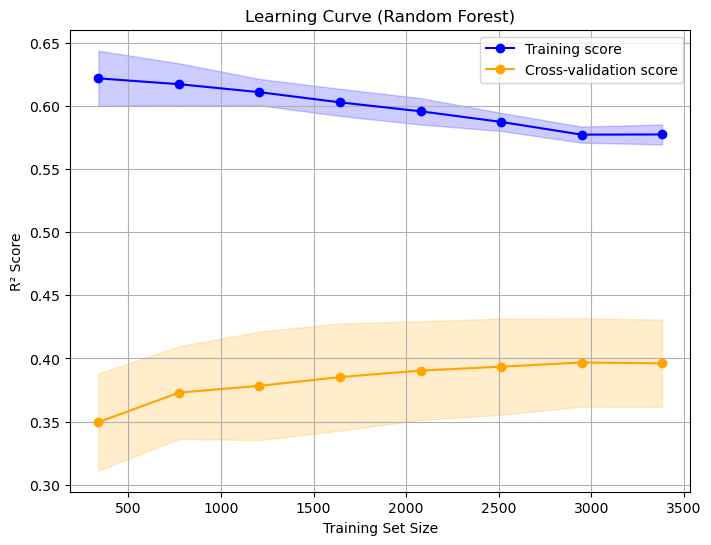

In [24]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid_search.best_estimator_,  # use your tuned RF
    X=X,
    y=y,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),  # from 10% to 100% of data
    shuffle=True,
    random_state=42
)

# Mean & std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="orange", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")

plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve (Random Forest)")
plt.legend(loc="best")
plt.grid(True)

plt.savefig("plots_train_val/learning_curve_rf_X.png", dpi=300, bbox_inches="tight")

plt.show()

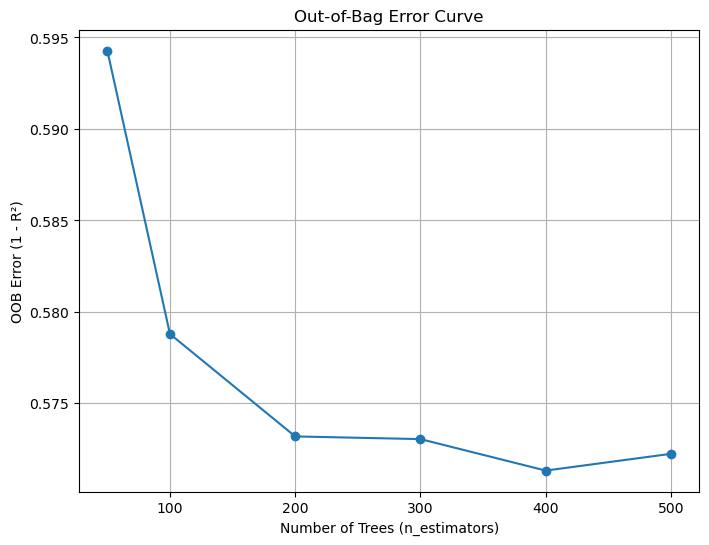

In [25]:
errors = []
n_estimators_range = [50, 100, 200, 300, 400, 500]

for n in n_estimators_range:
    rf = RandomForestRegressor(
        n_estimators=n,
        oob_score=True,
        random_state=42,
        n_jobs=-1,
        max_features="sqrt"
    )
    rf.fit(X, y)
    errors.append(1 - rf.oob_score_)  # OOB error = 1 - R²

plt.figure(figsize=(8,6))
plt.plot(n_estimators_range, errors, marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("OOB Error (1 - R²)")
plt.title("Out-of-Bag Error Curve")
plt.grid(True)

plt.savefig("plots_train_val/oob_error_rf_X.png", dpi=300, bbox_inches="tight")

plt.show()

In [26]:
# save best Random Forest model
best_rf = grid_search.best_estimator_

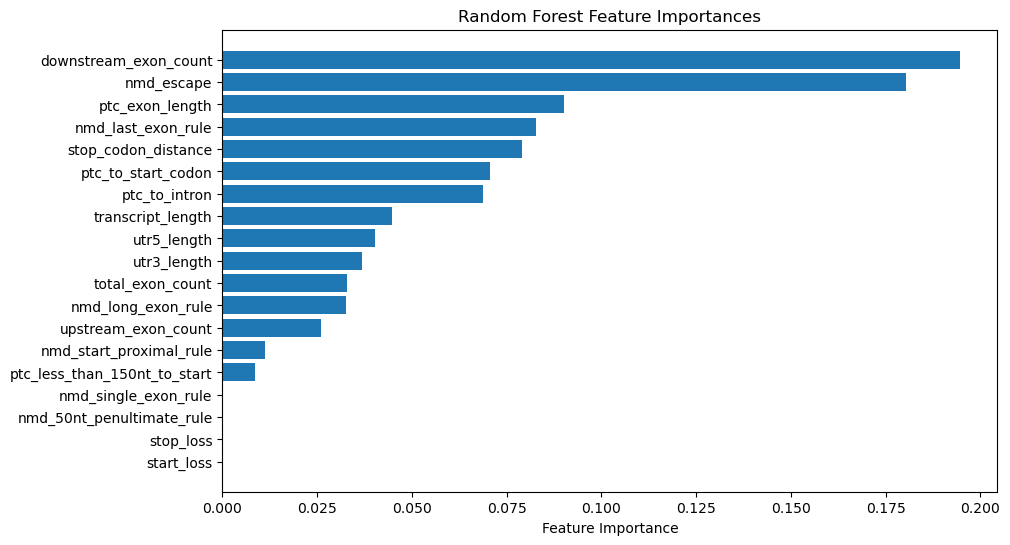

In [28]:
# Feature Importance
importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh(np.array(cols)[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()

plt.savefig("plots_train_val/feature_importance.png", dpi=300, bbox_inches="tight")

plt.show()

In [29]:
# Save the best model from our grid-search --> TODO: try this one in AbExp first to see how to integrate NMD-Scanner into AbExp, try improving model later

import joblib
joblib.dump(best_rf, "best_model.pkl")

# when deploying in AbExp, load the model like:
# model = joblib.load("random_forest_best_model.pkl")

['best_model.pkl']

In [30]:
print(df_filtered.columns.tolist())

['transcript_id', 'variant_id', 'ref_cds_start', 'ref_cds_stop', 'ref_cds_seq', 'ref_cds_len', 'alt_cds_start', 'alt_cds_stop', 'alt_cds_seq', 'alt_cds_len', 'chromosome', 'gene_id', 'strand', 'ref', 'alt', 'start_variant', 'end_variant', 'ref_cds_info', 'alt_cds_info', 'cds_in_transcript', 'ref_start_codon_pos', 'ref_start_codon_exon', 'ref_last_codon', 'ref_valid_stop', 'ref_first_stop_codon', 'ref_first_stop_pos', 'ref_num_stop_codons', 'ref_all_stop_codons', 'ref_stop_codon_exons', 'ref_is_premature', 'alt_start_codon_pos', 'alt_start_codon_exon', 'alt_last_codon', 'alt_valid_stop', 'alt_first_stop_codon', 'alt_first_stop_pos', 'alt_num_stop_codons', 'alt_all_stop_codons', 'alt_stop_codon_exons', 'alt_is_premature', 'start_loss', 'stop_loss', 'transcript_start', 'transcript_end', 'transcript_seq', 'transcript_length', 'alt_transcript_seq', 'alt_transcript_length', 'transcript_exon_info', 'transcript_start_codon_pos', 'transcript_start_codon_exon', 'transcript_last_codon', 'transcri

In [32]:
# Make a lookup dict from your importance_df

importance_df = pd.DataFrame({'feature':best_rf.feature_names_in_, 
                              'importance': best_rf.feature_importances_})

importance_df = importance_df.sort_values(by="importance", ascending=False).reset_index(drop=True)

importance_lookup = dict(zip(importance_df["feature"], importance_df["importance"]))

def format_p_value(p):
    if p < 0.001:
        return "p < 0.001"
    else:
        return f"p = {p:.3f}"

def compute_feature_correlations(df, features, target="NMD_efficiency"):
    results = []
    for feat in features:
        x = df[feat].dropna()
        y = df.loc[x.index, target].dropna()
        if len(x) > 5:  # avoid tiny groups
            pear, p_p = pearsonr(x, y)
            spear, p_s = spearmanr(x, y)            
            results.append({
                "feature": feat,
                "pearson_r": pear,
                # "spearman_r": spear,
                "p_value": format_p_value(p_p),
                "importance": importance_lookup.get(feat, None)
            })
    return pd.DataFrame(results)

#features = ["downstream_exon_count", "ptc_to_start_codon", "ptc_exon_length", "utr3_length", "ptc_to_intron", "stop_codon_distance", "nmd_last_exon_rule", "transcript_length", "utr5_length", 
#            "upstream_exon_count", "nmd_50nt_penultimate_rule"]
# missing features: LOEUF, mRNA half-life, AF

features = ['start_loss', 'stop_loss', 'total_exon_count', 'ptc_less_than_150nt_to_start', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape',
        'downstream_exon_count', 'nmd_last_exon_rule', 'ptc_to_start_codon', 
        'stop_codon_distance', 'ptc_exon_length', 'ptc_to_intron', 'upstream_exon_count', 
        'nmd_50nt_penultimate_rule', 'utr5_length' ,'utr3_length', 'transcript_length']

#features = ['start_loss', 'stop_loss', 'nmd_last_exon_rule', 'nmd_50nt_penultimate_rule', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape', # nmd escape = X or Y?
#        'utr3_length', 'utr5_length', 'alt_transcript_length', 'total_exon_count', 'upstream_exon_count', 'downstream_exon_count', 'ptc_to_start_codon', 'ptc_exon_length', 
#        'stop_codon_distance']

corr_df = compute_feature_correlations(df_filtered, features)
corr_df

/data/nasif12/modules_if12/SL7/i12g/anaconda/envs/florian4/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data/nasif12/modules_if12/SL7/i12g/anaconda/envs/florian4/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,feature,pearson_r,p_value,importance
0,start_loss,NaN,p = nan,0.000000
1,stop_loss,NaN,p = nan,0.000000
2,total_exon_count,0.148084,p < 0.001,0.032781
3,ptc_less_than_150nt_to_start,-0.135015,p < 0.001,0.008670
4,nmd_long_exon_rule,-0.452935,p < 0.001,0.032591
5,nmd_start_proximal_rule,-0.135015,p < 0.001,0.011168
6,nmd_single_exon_rule,-0.061257,p < 0.001,0.000202
7,nmd_escape,-0.515186,p < 0.001,0.180380
8,downstream_exon_count,0.257147,p < 0.001,0.194731
9,nmd_last_exon_rule,-0.474729,p < 0.001,0.082666


### Prediction

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.ensemble import RandomForestRegressor

In [3]:
# merge NMD_Scanner Output von MMRF mit dem NMD_efficiency score vom Original MMRF Benchmark
# df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/Output/MMRF_TARGET_dataset_final_nmd_results.csv')
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/Output-210925/MMRF_TARGET_dataset_final_nmd_results.csv')
df2 = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/MMRF_benchmark/MMRF_TARGET_dataset.csv')

# 1. Remove transcript version number from NMD Scanner output (df)
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]

# 2. Adjust start_variant position (+1) to match MMRF coordinates
df['start_variant'] = df['start_variant'] + 1
#df['end_variant'] = df['end_variant'] - 1

# 3. Rename TCGA columns to match NMD Scanner
df2 = df2.rename(columns={
    'Transcript_ID': 'transcript_id',
    'start': 'start_variant'
})

# 4. Select only relevant columns from MMRF
df2_subset = df2[['transcript_id', 'start_variant', 'NMD_efficiency']]

# 5. Merge
df_merged = pd.merge(df, df2_subset, on=['transcript_id', 'start_variant'], how='inner')

# ✅ Inspect result
print("Merged shape:", df_merged.shape)
print("Missing NMD_efficiency values:", df_merged['NMD_efficiency'].isnull().sum())
print(df_merged[['transcript_id', 'start_variant', 'NMD_efficiency']].head())

Merged shape: (549, 75)
Missing NMD_efficiency values: 0
     transcript_id  start_variant  NMD_efficiency
0  ENST00000038176       58609624        0.710493
1  ENST00000040738       13576985        0.022368
2  ENST00000155093        2979509       -0.019109
3  ENST00000156471       34857043        0.040062
4  ENST00000202917      112917610        0.987014


In [4]:
# Select the columns that we want to have as X (our features)
#cols = ['start_loss', 'stop_loss', 'nmd_last_exon_rule', 'nmd_50nt_penultimate_rule', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape', # nmd escape = X or Y?
#        'utr3_length', 'utr5_length', 'alt_transcript_length', 'total_exon_count', 'upstream_exon_count', 'downstream_exon_count', 'ptc_to_start_codon', 'ptc_exon_length', 
#        'stop_codon_distance'] 

# new features:
cols = ['start_loss', 'stop_loss', 'total_exon_count', 'ptc_less_than_150nt_to_start', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape',
        'downstream_exon_count', 'nmd_last_exon_rule', 'ptc_to_start_codon', 
        'stop_codon_distance', 'ptc_exon_length', 'ptc_to_intron', 'upstream_exon_count', 
        'nmd_50nt_penultimate_rule', 'utr5_length' ,'utr3_length', 'transcript_length']


df_merged[cols].head(1)

,start_loss,stop_loss,total_exon_count,ptc_less_than_150nt_to_start,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,downstream_exon_count,nmd_last_exon_rule,ptc_to_start_codon,stop_codon_distance,ptc_exon_length,ptc_to_intron,upstream_exon_count,nmd_50nt_penultimate_rule,utr5_length,utr3_length,transcript_length
0,False,False,31,False,False,False,False,False,21.0,False,666.0,2085.0,130.0,21.0,9.0,False,598,222.0,3574


In [5]:
df_merged[cols].isnull().sum()

start_loss                       0
stop_loss                        0
total_exon_count                 0
ptc_less_than_150nt_to_start     0
nmd_long_exon_rule               0
nmd_start_proximal_rule          0
nmd_single_exon_rule             0
nmd_escape                       0
downstream_exon_count            1
nmd_last_exon_rule               0
ptc_to_start_codon              11
stop_codon_distance             39
ptc_exon_length                  1
ptc_to_intron                    1
upstream_exon_count              1
nmd_50nt_penultimate_rule        0
utr5_length                      0
utr3_length                     10
transcript_length                0
dtype: int64

In [6]:
# drop non-PTCs: if alt_is_premature = False, und falls alt_is_premature = True dann darf ref_is_premature nicht True sein

# 1. remove rows with ref_is_premature = True weil dann ist Annotations-Fehler und falls alt_is_premature = True dann ist es nicht premature
df_filtered = df_merged[~df_merged["ref_is_premature"]]
rem_rows1 = df_merged.shape[0] - df_filtered.shape[0]

print(f"Rows removed in step 1 (ref_is_premature=True): {rem_rows1}")
print(f"Remaining rows: {df_filtered.shape[0]}")

# 2. remove rows with ref_is_premature = False und alt_is_premature = False
step2_rows = df_filtered.shape[0]
df_filtered = df_filtered[~((df_filtered["ref_is_premature"] == False) & (df_filtered["alt_is_premature"] == False))]
rem_rows2 = step2_rows - df_filtered.shape[0]

print(f"Rows removed in step 2 (both ref and alt not premature): {rem_rows2}")
print(f"Remaining rows: {df_filtered.shape[0]}")

df_filtered = df_filtered.reset_index(drop=True)
df_filtered.head()

Rows removed in step 1 (ref_is_premature=True): 1
Remaining rows: 548
Rows removed in step 2 (both ref and alt not premature): 1
Remaining rows: 547


,transcript_id,variant_id,ref_cds_start,ref_cds_stop,ref_cds_seq,ref_cds_len,alt_cds_start,alt_cds_stop,alt_cds_seq,alt_cds_len,...,ptc_exon_length,stop_codon_distance,ptc_to_intron,nmd_last_exon_rule,nmd_50nt_penultimate_rule,nmd_long_exon_rule,nmd_start_proximal_rule,nmd_single_exon_rule,nmd_escape,NMD_efficiency
0,ENST00000038176,.,58584105,58659631,ATGGCGTTTATCCGGAAGAAGCAGCAGGAGCAGCAGCTGCAGCTCT...,2754,58584105,58659631,ATGGCGTTTATCCGGAAGAAGCAGCAGGAGCAGCAGCTGCAGCTCT...,2754,...,130.0,2085.0,21.0,False,False,False,False,False,False,0.710493
1,ENST00000040738,.,13570010,13627587,ATGGCCACCAACCCACAGCCGCAGCCGCCTCCTCCGGCGCCGCCGC...,9156,13570010,13627587,ATGGCCACCAACCCACAGCCGCAGCCGCCTCCTCCGGCGCCGCCGC...,9156,...,154.0,264.0,149.0,False,False,False,False,False,False,0.022368
2,ENST00000155093,.,2953936,2979993,ATGGATGAAGATGAATTTGAATTGCAGCCACAAGAGCCAAACTCAT...,2406,2953936,2979993,ATGGATGAAGATGAATTTGAATTGCAGCCACAAGAGCCAAACTCAT...,2406,...,3697.0,483.0,486.0,True,False,True,False,False,True,-0.019109
3,ENST00000156471,.,34856791,34969613,ATGGCAGCCCCTGCGCAGCCCAAGAAGATCGTGGCCCCTACGGTGT...,4458,34856791,34969613,ATGGCAGCCCCTGCGCAGCCCAAGAAGATCGTGGCCCCTACGGTGT...,4458,...,5325.0,249.0,252.0,True,False,True,False,False,True,0.040062
4,ENST00000202917,.,112907039,112919553,ATGATGGATCTCAGAAATACCCCAGCCAAATCTCTGGACAAGTTCA...,1203,112907039,112919553,ATGATGGATCTCAGAAATACCCCAGCCAAATCTCTGGACAAGTTCA...,1203,...,154.0,255.0,93.0,False,False,False,False,False,False,0.987014


In [7]:
df_filtered[cols].isnull().sum()

start_loss                       0
stop_loss                        0
total_exon_count                 0
ptc_less_than_150nt_to_start     0
nmd_long_exon_rule               0
nmd_start_proximal_rule          0
nmd_single_exon_rule             0
nmd_escape                       0
downstream_exon_count            0
nmd_last_exon_rule               0
ptc_to_start_codon              10
stop_codon_distance             38
ptc_exon_length                  0
ptc_to_intron                    0
upstream_exon_count              0
nmd_50nt_penultimate_rule        0
utr5_length                      0
utr3_length                      9
transcript_length                0
dtype: int64

In [8]:
# drop null values
df_filtered = df_filtered.loc[df_filtered['stop_codon_distance'].notnull()].reset_index(drop=True)
df_filtered = df_filtered.loc[df_filtered['ptc_to_start_codon'].notnull()].reset_index(drop=True)
df_filtered.shape

(507, 75)

In [9]:
df_filtered[cols].isnull().sum()

start_loss                      0
stop_loss                       0
total_exon_count                0
ptc_less_than_150nt_to_start    0
nmd_long_exon_rule              0
nmd_start_proximal_rule         0
nmd_single_exon_rule            0
nmd_escape                      0
downstream_exon_count           0
nmd_last_exon_rule              0
ptc_to_start_codon              0
stop_codon_distance             0
ptc_exon_length                 0
ptc_to_intron                   0
upstream_exon_count             0
nmd_50nt_penultimate_rule       0
utr5_length                     0
utr3_length                     0
transcript_length               0
dtype: int64

In [12]:
regr = joblib.load("best_model.pkl")

def predict_NMD_efficiency(start_loss:bool, stop_loss:bool, nmd_last_exon_rule:bool, nmd_50nt_penultimate_rule:bool, 
                           nmd_long_exon_rule:bool, nmd_start_proximal_rule:bool, nmd_single_exon_rule:bool, nmd_escape:bool,
                           utr3_length:int, utr5_length:int, transcript_length:float, total_exon_count:float, 
                           upstream_exon_count:float, downstream_exon_count:float, ptc_to_start_codon:float, ptc_exon_length:float,
                           stop_codon_distance:float, ptc_less_than_150nt_to_start:bool, ptc_to_intron:float, alt_is_premature:bool):
    
    input_value =[[start_loss, stop_loss, nmd_last_exon_rule, nmd_50nt_penultimate_rule, nmd_long_exon_rule, nmd_start_proximal_rule, 
                   nmd_single_exon_rule, nmd_escape, utr3_length, utr5_length, transcript_length, total_exon_count, 
                   upstream_exon_count, downstream_exon_count, ptc_to_start_codon, ptc_exon_length, stop_codon_distance,
                  ptc_less_than_150nt_to_start, ptc_to_intron, alt_is_premature]]

    
    assert sum([np.isnan(value) for value in input_value[0]]) == 0, 'Replace NaN value'
    
    pred = regr.predict(input_value)[0]
    
    return pred


def predict_NMD_efficiency_df(examples):
    df_merged = pd.DataFrame(examples)

    assert df_merged.isnull().sum().sum() == 0, 'Replace NaN value'

    pred = regr.predict(df_merged)

    return pred

In [13]:
pred = regr.predict(df_filtered[cols])
c, p = stats.pearsonr(pred, df_filtered['NMD_efficiency'])
print("Pearson R :" , c)
print("P-value : " , p)

Pearson R : 0.4352453632795195
P-value :  7.519835585973141e-25


Pearson R: 0.4352453632795195
P-value: 7.519835585973141e-25
R^2: 0.1894385262563209


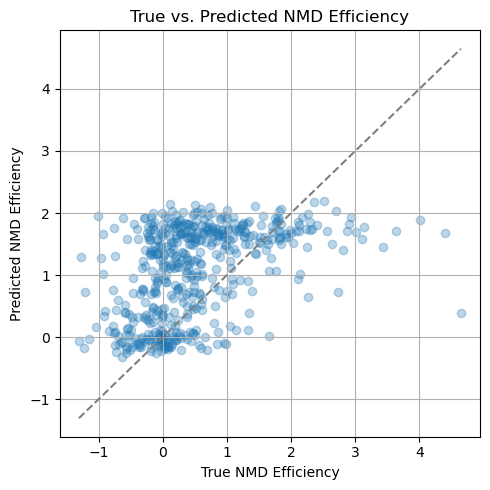

In [15]:
y_true = df_filtered['NMD_efficiency']
y_pred = regr.predict(df_filtered[cols]) # = pred

# Pearson correlation
c, p = stats.pearsonr(y_pred, y_true)
print("Pearson R:", c)
print("P-value:", p)
print("R^2:", np.square(c))

# min / max value for line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())

# Plot: True vs Predicted
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')
plt.xlabel("True NMD Efficiency")
plt.ylabel("Predicted NMD Efficiency")
plt.title("True vs. Predicted NMD Efficiency")
plt.grid(True)
plt.tight_layout()

plt.savefig("plots_train_val/scatter_plot.png", dpi=300, bbox_inches="tight")

plt.show()

Random Forest (MMRF validation)
Pearson R: 0.43524536327951946
P-value: 7.519835585973141e-25
R^2 (sklearn): -0.36582538220404226
R^2: 0.18943852625632088


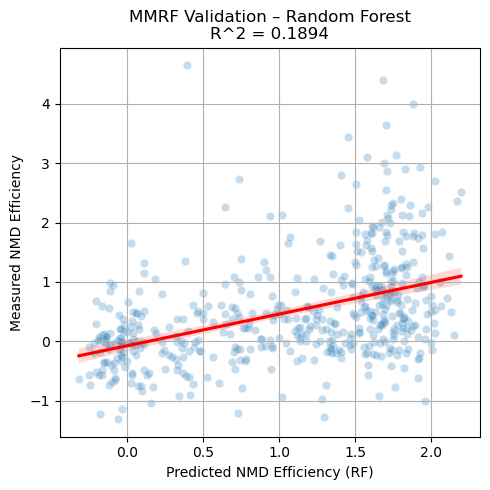

In [18]:
#TODO: create & show scatter plot on validation dataset (geom_point() + geom_smooth(method='lm')) → first for RF and then for binary as well
#TODO: show R^2 for validation set of canonical rules vs. RFs

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns

# Validation features & labels (MMRF dataset)
y_val = df_filtered['NMD_efficiency']
X_val = df_filtered[cols]

# 1) Random Forest predictions
y_pred_rf = regr.predict(X_val)

c_rf, p_rf = stats.pearsonr(y_pred_rf, y_val)
c2_rf = r2_score(y_val, y_pred_rf)

print("Random Forest (MMRF validation)")
print("Pearson R:", c_rf)
print("P-value:", p_rf)
print("R^2 (sklearn):", c2_rf)
print("R^2:", np.square(c_rf))

# Scatter plot (RF)
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_pred_rf, y=y_val, alpha=0.25)
sns.regplot(x=y_pred_rf, y=y_val, scatter=False, color="red")

plt.ylabel("Measured NMD Efficiency")
plt.xlabel("Predicted NMD Efficiency (RF)")
plt.title(f"MMRF Validation – Random Forest\nR^2 = {np.square(c_rf):.4f}")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
df_filtered.columns

Index(['transcript_id', 'variant_id', 'ref_cds_start', 'ref_cds_stop',
       'ref_cds_seq', 'ref_cds_len', 'alt_cds_start', 'alt_cds_stop',
       'alt_cds_seq', 'alt_cds_len', 'chromosome', 'gene_id', 'strand', 'ref',
       'alt', 'start_variant', 'end_variant', 'ref_cds_info', 'alt_cds_info',
       'cds_in_transcript', 'ref_start_codon_pos', 'ref_start_codon_exon',
       'ref_last_codon', 'ref_valid_stop', 'ref_first_stop_codon',
       'ref_first_stop_pos', 'ref_num_stop_codons', 'ref_all_stop_codons',
       'ref_stop_codon_exons', 'ref_is_premature', 'alt_start_codon_pos',
       'alt_start_codon_exon', 'alt_last_codon', 'alt_valid_stop',
       'alt_first_stop_codon', 'alt_first_stop_pos', 'alt_num_stop_codons',
       'alt_all_stop_codons', 'alt_stop_codon_exons', 'alt_is_premature',
       'start_loss', 'stop_loss', 'transcript_start', 'transcript_end',
       'transcript_seq', 'transcript_length', 'alt_transcript_seq',
       'alt_transcript_length', 'transcript_exon_info'

predicted nmd_escape vs actual NMD_efficiency
Pearson R: -0.32281426698374177
P-value: 9.251987274881172e-14
R^2: 0.10420905096825052


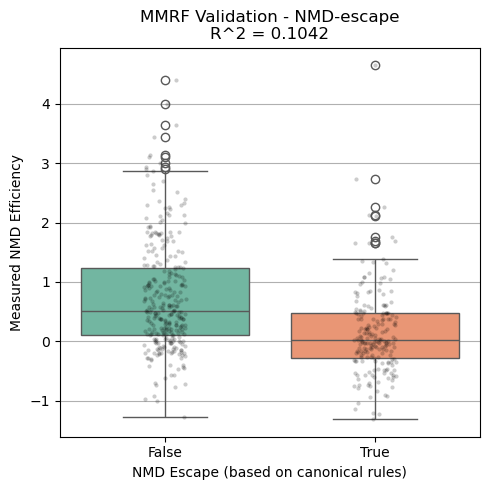

In [21]:
import seaborn as sns
import numpy as np
from scipy import stats

# Data
x = df_filtered['nmd_escape'].astype(int)  # False = 0, True = 1
y = df_filtered['NMD_efficiency'] # actual NMD efficiency scores

# Pearson correlation (point-biserial)
c, p = stats.pearsonr(x, y)
print("predicted nmd_escape vs actual NMD_efficiency")
print("Pearson R:", c)
print("P-value:", p)
print("R^2:", np.square(c))


plt.figure(figsize=(5, 5))

sns.boxplot(data=df_filtered, x="nmd_escape", y="NMD_efficiency", hue="nmd_escape", palette="Set2", legend=False)
sns.stripplot(data=df_filtered, x="nmd_escape", y="NMD_efficiency", color="black", alpha=0.2, jitter=True, size=3)

plt.xlabel("NMD Escape (based on canonical rules)")
plt.ylabel("Measured NMD Efficiency")
plt.title(f"MMRF Validation - NMD-escape\nR^2 = {np.square(c):.4f}")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
Scatterplot of table: actual and canonical nmd rule yes or no
column nmd-escape yes or no from NMD-Scanner --> use this column
compare to nmd efficiency score 
r2 

basically this plot on slide 11 and for that I have an R-squared
and compare this one to the NMD-efficiency predicted against actual


Canonical rules (MMRF validation)
Pearson R: 0.3678369684715052
P-value: 1.0892518024122624e-17
R^2 (sklearn): 0.13530403537430702
R^2: 0.13530403537430713


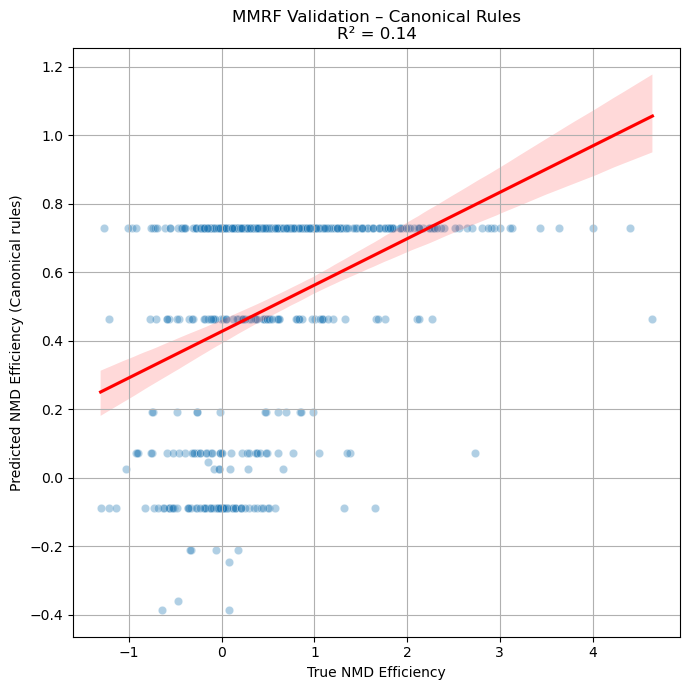

In [66]:
# 2) Canonical (binary rules) baseline

canonical_cols = [
    'nmd_last_exon_rule',
    'nmd_50nt_penultimate_rule',
    'nmd_long_exon_rule',
    'nmd_start_proximal_rule',
    'nmd_single_exon_rule',
    'nmd_escape'
]

# Fit canonical model on MMRF (rules have no training state)
linreg = LinearRegression()
linreg.fit(X_val[canonical_cols], y_val)

y_pred_canonical = linreg.predict(X_val[canonical_cols])

c_can, p_can = stats.pearsonr(y_pred_canonical, y_val)
c2_can = r2_score(y_val, y_pred_canonical)

print("Canonical rules (MMRF validation)")
print("Pearson R:", c_can)
print("P-value:", p_can)
print("R^2 (sklearn):", c2_can)
print("R^2:", np.square(c_can))

# Scatter plot (Canonical)
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_val, y=y_pred_canonical, alpha=0.35)
sns.regplot(x=y_val, y=y_pred_canonical, scatter=False, color="red")

plt.xlabel("True NMD Efficiency")
plt.ylabel("Predicted NMD Efficiency (Canonical rules)")
plt.title(f"MMRF Validation – Canonical Rules\nR² = {r2_can:.2f}")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 3) Summary table (for slides)

pd.DataFrame({
    "Model": ["Canonical rules", "Random Forest"],
    "Pearson R": [r_can, r_rf],
    "R² (MMRF validation)": [r2_can, r2_rf]
})

# Analyse der NaN Werte in df

In [ ]:
df["stop_codon_distance_nmd"] = df["ref_first_stop_pos"] - df["alt_first_stop_pos"]

In [ ]:
df.shape

In [ ]:
df[cols].isnull().sum()

In [ ]:
# Prüfen, ob dieselben Zeilen NaNs in allen 4 Spalten haben
upstream = df["upstream_exon_count"].isnull()
total = df["total_exon_count"].isnull()
downstream = df["downstream_exon_count"].isnull()
ptc_exon_length = df["ptc_exon_length"].isnull()

# Vergleichen, ob alle Zeilen identisch sind
same_rows = (
    (upstream == total) &
    (total == downstream) &
    (downstream == ptc_exon_length)
)

print("Alle 4 Spalten NaN in denselben Zeilen:", same_rows.all())  # Sollte True sein

In [ ]:
# Zeige nur die Zeilen mit NaNs in exon-relevanten Spalten
df[total][["transcript_id", "total_exon_count", "nmd_single_exon_rule"]].head()

In [ ]:
# Bedingung: Alle vier Spalten sind NaN
mask = df[[
    "upstream_exon_count",
    "total_exon_count",
    "downstream_exon_count",
    "ptc_exon_length"
]].isnull().all(axis=1)

# Zeige alle betroffenen Zeilen (komplett)
pd.set_option("display.max_columns", None)  # Zeige alle Spalten
pd.set_option("display.max_rows", 100)      # Falls viele Zeilen, begrenze ggf.
df_nan_rows = df[mask]
df_nan_rows

In [ ]:
# check if all rows have start_loss or stop_loss = False, in that case, transcript information will be NaN

all_both_false = (df_nan_rows["start_loss"] == False) & (df_nan_rows["stop_loss"] == False)

print("Anzahl der Zeilen mit NaNs in den vier Spalten:", len(df_nan_rows))
print("Anzahl dieser Zeilen, bei denen start_loss UND stop_loss False sind:", all_both_false.sum())

# Optional: Zeige nur die Zeilen, wo das NICHT zutrifft (zur Kontrolle)
df_nan_rows[~all_both_false]

In [ ]:
# check if alt_is_premature = FALSE in all cases
all_false = (df_nan_rows["alt_is_premature"] == False).all()
print("alt_is_premature überall False:", all_false)

In [ ]:
# Wahrscheinlich kommen die 217 Null-Werte in total_exon_count, downstream_exon_count, upstream_exon_count und ptc_exon_length daher, dass alt_is_premature = False ist. 
# Jetzt will ich mir die anderen columns mit den Null Werten anschauen. Dafür extrahiere ich alle Zeilen wo alt_transcript_length = NaN da hier die höchste Zahl ist, und schaue nach,
# ob die anderen NaN Werte hier drin enthalten sind.

In [ ]:
df[cols].isnull().sum()

In [ ]:
# check if ptc_to_start_codon = NaN is because we do not have a PTC

# Check, ob ptc_to_start_codon NaN ist, weil kein PTC vorhanden ist
ptcstartcodon_df = df["ptc_to_start_codon"].isnull()
df_na = df[ptcstartcodon_df].copy()

# Überprüfen, ob überall alt_is_premature == False
all_false = (df_na["alt_is_premature"] == False).all()
print("alt_is_premature überall False:", all_false)

# Zähle wie oft False bzw. True vorkommt
value_counts = df_na["alt_is_premature"].value_counts(dropna=False)
print("\nVerteilung von alt_is_premature bei fehlendem ptc_to_start_codon:")
print(value_counts)

In [ ]:
# Zeilen mit NaN in alt_transcript_length
alt_transcript_na = df["alt_transcript_length"].isnull()

# Neues DataFrame mit diesen 1854 Zeilen
df_alt_na = df[alt_transcript_na].copy()

# Anzahl dieser Zeilen (sollte 1854 sein)
print("Anzahl Zeilen mit alt_transcript_length NaN:", df_alt_na.shape[0])

# Prüfen, wie viele davon auch andere Spalten als NaN haben
null_counts_in_alt_na = df_alt_na[[
    "total_exon_count",
    "upstream_exon_count",
    "downstream_exon_count",
    "ptc_exon_length",
    "ptc_to_start_codon",
    "stop_codon_distance_nmd"
]].isnull().sum()

print("NaN-Werte innerhalb der 1854 alt_transcript_length-NaNs:")
print(null_counts_in_alt_na)

# Wie viele der 1854 haben alt_is_premature == False?
false_premature_count = df_alt_na["alt_is_premature"] == False
print("Anzahl alt_is_premature == False innerhalb der 1854:", false_premature_count.sum())

In [ ]:
# Grund für alt_transcript_length = NaN ist weil cds_in_transcript = False ist, d.h. das CDS konnte nicht im Transkript festgestellt werden

# Anzahl der Fälle, in denen cds_in_transcript == False
cds_false_count = df[df["cds_in_transcript"] == False].shape[0]

# Anzahl der Fälle, in denen alt_transcript_length == NaN
alt_len_nan_count = df["alt_transcript_length"].isnull().sum()

# Anzahl der Fälle, in denen cds_in_transcript == False und alt_transcript_length == NaN
both_condition_count = df[(df["cds_in_transcript"] == False) & (df["alt_transcript_length"].isnull())].shape[0]

print(f"cds_in_transcript == False: {cds_false_count}")
print(f"alt_transcript_length == NaN: {alt_len_nan_count}")
print(f"Beides gleichzeitig: {both_condition_count}")
print(f"Vollständige Übereinstimmung: {cds_false_count == alt_len_nan_count == both_condition_count}")

# Create my own Model

In [ ]:
# merge NMD_Scanner Output von TCGA mit dem NMD_efficiency score vom Original TCGA Benchmark
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset_final_nmd_results.csv')
df2 = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset.csv')

# 1. Remove transcript version number from NMD Scanner output (df)
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]

# 2. Adjust start_variant position (+1) to match TCGA coordinates
df['start_variant'] = df['start_variant'] + 1
#df['end_variant'] = df['end_variant'] - 1

# 3. Rename TCGA columns to match NMD Scanner
df2 = df2.rename(columns={
    'Transcript_ID': 'transcript_id',
    'start': 'start_variant',
    'end': 'end_variant'
})

# 4. Select only relevant columns from TCGA
df2_subset = df2[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']]

# 5. Merge
df_merged = pd.merge(df, df2_subset, on=['transcript_id', 'start_variant', 'end_variant'], how='inner')

# 6. add distance to stop codon feature --> will it be a problem later on when I want to include it in AbExp?
df_merged["stop_codon_distance_nmd"] = df_merged["ref_first_stop_pos"] - df_merged["alt_first_stop_pos"]

# Select the columns that we want to have as X (our features)
cols = ['start_loss', 'stop_loss', 'nmd_last_exon_rule', 'nmd_50nt_penultimate_rule', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape', # nmd escape = X or Y?
        'utr3_length', 'utr5_length', 'alt_transcript_length', 'total_exon_count', 'upstream_exon_count', 'downstream_exon_count', 'ptc_to_start_codon', 'ptc_exon_length', 
        'stop_codon_distance_nmd'] 

# drop null values --> LightGBM can handle this
#df_merged = df_merged.loc[df_merged['alt_transcript_length'].notnull()].reset_index(drop=True)
#df_merged = df_merged.loc[df_merged['ptc_to_start_codon'].notnull()].reset_index(drop=True)

X = df_merged[cols]
y = df_merged['NMD_efficiency']

print("Merged shape:", df_merged.shape)
print("Missing NMD_efficiency values:", df_merged['NMD_efficiency'].isnull().sum())
print(df_merged[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']].head())

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_merged[cols].isnull().sum()

In [ ]:
# First try models who can handle NaN values
models = {
    "XGBoost": xgb.XGBRegressor(n_estimators=500, learning_rate=0.05),
    "LightGBM": LGBMRegressor(n_estimators=500),
}

print("Model Comparison (5-fold CV, R² Scores):")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"{name:15s} | R²: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

In [ ]:
# Try imputation for models which can't handle NaN values

nan_sensitive_models = {
    "Random Forest": RandomForestRegressor(n_estimators=500, max_features=3),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=500),
    "Ridge": Ridge(),
    "Lasso": Lasso(alpha=0.01),
    "SVR": SVR()
}

# Evaluate models that need NaNs removed or imputed
print("\nModels that need NaNs handled:")

# Create imputation pipeline (mean imputation as a start)
imputer = SimpleImputer(strategy='mean')

for name, model in nan_sensitive_models.items():
    pipe = Pipeline([
        ('imputer', imputer),
        ('model', model)
    ])
    scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')
    print(f"{name:20s} | R²: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

In [ ]:
df_merged[cols].isnull().sum()

In [ ]:
# Now remove NaN values
df_merged = df_merged.loc[df_merged['alt_transcript_length'].notnull()].reset_index(drop=True)
df_merged = df_merged.loc[df_merged['ptc_to_start_codon'].notnull()].reset_index(drop=True)
df_merged[cols].isnull().sum()

X = df_merged[cols]
y = df_merged['NMD_efficiency']

In [ ]:
df_merged[cols].isnull().sum()

In [ ]:
# Try different models --> some accept NaNs some not
models = {
    "Random Forest": RandomForestRegressor(n_estimators=500, max_features=3),
    "XGBoost": xgb.XGBRegressor(n_estimators=500, learning_rate=0.05),
    "LightGBM": LGBMRegressor(n_estimators=500),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=500),    
    "Ridge": Ridge(),
    "Lasso": Lasso(alpha=0.01),
    "SVR": SVR()
}

print("Model Comparison (5-fold CV, R² Scores):")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"{name:15s} | R²: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

In [ ]:
# make sure no NaNs for this model since it had best R2-score
df_merged[cols].isnull().sum()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import numpy as np

# Define X and y from your earlier code
X = df_merged[cols]
y = df_merged['NMD_efficiency']

# Try doing Grid-Search
param_grid = {
    'n_estimators': [100, 300, 500], #
    'max_depth': [None, 3, 5, 10],
    'max_features': ['sqrt', 0.3, 0.5], #
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2], #
    # 'criterion': ['gini', 'entropy']
}

refined_grid = {
    'n_estimators': [250, 300, 350],
    'max_depth': [8, 10, 12],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3]
}

refined_grid2 = {
    'n_estimators': [230, 250, 270],
    'max_depth': [10, 11, 12],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

refined_grid3 = {
    'n_estimators': [100, 150, 200, 230, 250],
    'max_depth': [10],
    'max_features': ['sqrt'],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 2]
}

regr = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=regr,
    param_grid=refined_grid3, # param_grid
    scoring='r2',
    cv=5,
    verbose=2, # Shows progress in terminal
    n_jobs=-1 # Use all cores
)

grid_search.fit(X, y)

print("\nBest Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)

In [ ]:
# save best Random Forest model
best_rf = grid_search.best_estimator_

In [ ]:
# Feature Importance

import matplotlib.pyplot as plt
import numpy as np

importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh(np.array(cols)[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Save the best model from our grid-search --> TODO: try this one in AbExp first to see how to integrate NMD-Scanner into AbExp, try improving model later

import joblib
joblib.dump(best_rf, "random_forest_nmd.pkl")

# when deploying in AbExp, load the model like:
# model = joblib.load("random_forest_best_model.pkl")

In [ ]:
# Train another model on Imputing 



In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training
model = LGBMRegressor(n_estimators=500)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Metriken
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")

# Plot: true vs. predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel('True NMD Efficiency')
plt.ylabel('Predicted NMD Efficiency')
plt.title('Predicted vs. True Values')
plt.tight_layout()
plt.show()

In [ ]:
# Try Feature selection

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Selected features:", list(selected_features))

In [ ]:
# Try hyperparameter tuning for the best model

from sklearn.model_selection import GridSearchCV # or RandomizedSearchCV 

param_grid = {
    'max_depth': [3, 5, 10, None],
    'max_features': [3, 5, 'sqrt'],
    'n_estimators': [500, 1000],
}

grid_search = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)
print("Best parameters:", grid_search.best_params_)
print("Best R²:", grid_search.best_score_)


In [ ]:
# Metrics for a Regression task

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import numpy as np

y_pred = regr.predict(X_test)

# Core metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Correlations
pearson_r, pearson_p = pearsonr(y_test, y_pred)
spearman_r, spearman_p = spearmanr(y_test, y_pred)

# Print all
print(f"MAE:       {mae:.4f}")
print(f"MSE:       {mse:.4f}")
print(f"RMSE:      {rmse:.4f}")
print(f"R²:        {r2:.4f}")
print(f"Pearson r: {pearson_r:.4f} (p={pearson_p:.4e})")
print(f"Spearman r:{spearman_r:.4f} (p={spearman_p:.4e})")


In [ ]:
# Create new RandomForestRegressor model but instead of removing NaNs, we impute them:


# merge NMD_Scanner Output von TCGA mit dem NMD_efficiency score vom Original TCGA Benchmark
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset_final_nmd_results.csv')
df2 = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset.csv')

# 1. Remove transcript version number from NMD Scanner output (df)
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]

# 2. Adjust start_variant position (+1) to match TCGA coordinates
df['start_variant'] = df['start_variant'] + 1
#df['end_variant'] = df['end_variant'] - 1

# 3. Rename TCGA columns to match NMD Scanner
df2 = df2.rename(columns={
    'Transcript_ID': 'transcript_id',
    'start': 'start_variant',
    'end': 'end_variant'
})

# 4. Select only relevant columns from TCGA
df2_subset = df2[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']]

# 5. Merge
df_merged = pd.merge(df, df2_subset, on=['transcript_id', 'start_variant', 'end_variant'], how='inner')

# 6. add distance to stop codon feature --> will it be a problem later on when I want to include it in AbExp?
df_merged["stop_codon_distance_nmd"] = df_merged["ref_first_stop_pos"] - df_merged["alt_first_stop_pos"]

# Select the columns that we want to have as X (our features)
cols = ['start_loss', 'stop_loss', 'nmd_last_exon_rule', 'nmd_50nt_penultimate_rule', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape', # nmd escape = X or Y?
        'utr3_length', 'utr5_length', 'alt_transcript_length', 'total_exon_count', 'upstream_exon_count', 'downstream_exon_count', 'ptc_to_start_codon', 'ptc_exon_length', 
        'stop_codon_distance_nmd'] 

# drop null values --> LightGBM can handle this
#df_merged = df_merged.loc[df_merged['alt_transcript_length'].notnull()].reset_index(drop=True)
#df_merged = df_merged.loc[df_merged['ptc_to_start_codon'].notnull()].reset_index(drop=True)

X = df_merged[cols]
y = df_merged['NMD_efficiency']

print("Merged shape:", df_merged.shape)
print("Missing NMD_efficiency values:", df_merged['NMD_efficiency'].isnull().sum())
print(df_merged[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']].head())

In [ ]:
df_merged[cols].isnull().sum()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# feature matrix and target
X = df_merged[cols]
y = df_merged['NMD_efficiency']

# Define a pipeline: imputer + random forest
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # or 'median', 'most_frequent', etc.
    ('regr', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# grid search
param_grid = {
    'regr__n_estimators': [100, 300, 500],
    'regr__max_depth': [None, 3, 5, 10],
    'regr__max_features': ['sqrt', 0.3, 0.5],
    'regr__min_samples_split': [2, 5, 10],
    'regr__min_samples_leaf': [1, 2],
}

param_grid2 = {
    'regr__n_estimators': [280, 300, 320],
    'regr__max_depth': [7, 10, 13],
    'regr__max_features': [0.2, 0.3, 0.4],
    'regr__min_samples_split': [5, 10, 15],
    'regr__min_samples_leaf': [1, 2, 3],
}

param_grid3 = {
    'regr__n_estimators': [320, 350],
    'regr__max_depth': [13, 14, 15],
    'regr__max_features': [0.2],
    'regr__min_samples_split': [15, 20, 25],
    'regr__min_samples_leaf': [3, 4, 5],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X, y)

print("\nBest Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)


In [ ]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid3,
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1,
    return_train_score=True  # enable train scores
)

grid_search.fit(X, y)

results = grid_search.cv_results_

for mean_train, mean_test, params in zip(results['mean_train_score'], results['mean_test_score'], results['params']):
    print(f"Train R²: {mean_train:.3f} | CV R²: {mean_test:.3f} | Params: {params}")

In [ ]:
# save best Random Forest model
best_rf = grid_search.best_estimator_

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importances = best_rf.named_steps['regr'].feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh(np.array(cols)[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import joblib
joblib.dump(best_rf, "RF_imputed_model.pkl")